## Import libraries

In [127]:
#For data manipulation
import numpy as np
import pandas as pd
import copy

# Import libraries
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

# Import matplotlib and set the style for data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import seaborn as sns

# Import yfinance and Fred API to fetch historical data
import yfinance as yf
from fredapi import Fred
fred = Fred(api_key='my-key')

# Import library for portfolio optimization
# Import library for optimization
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import objective_functions

# Import dendrogram, linkage to create dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Import StandardScaler from sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

# Import AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# Import libraries for backtesting
import pyfolio as pf
import riskfolio as rp

## Define investment universe

In [2]:
# Investment Universe
equities = 'ACWI'# iShares MSCI ACWI - 28.03.2008
nom_bonds = 'PLW'# Invesco 1-30 Laddered Treasury - 11.10.2007
il_bonds = 'TIP' # iShares TIPS Bond - 05.12.2003
corp_bonds = 'LQD' # iShares iBoxx $ Investment Grade Corporate Bond - 30.07.2002
em_bonds = 'EMB'# iShares J.P. Morgan USD Emerging Markets Bond - 19.12.2007
commod = 'DBC' # Invesco DB Commodity Index Tracking Fund - 06.02.2006

tickers = ['ACWI', 'PLW', 'TIP', 'LQD', 'EMB', 'DBC']

## Fetch data

In [3]:
prices = pd.DataFrame(yf.download(tickers, start='2008-06-30', end='2022-07-30', interval='1d')['Adj Close'])

[*********************100%***********************]  6 of 6 completed


In [4]:
prices.head()

ACWI        DBC        EMB        LQD        PLW        TIP
Date                                                                        
2008-06-30  37.393311  42.833363  50.243698  59.823021  19.084896  73.375954
2008-07-01  37.105782  43.589016  49.977249  59.795776  19.121113  73.394463
2008-07-02  36.523167  44.421200  50.109722  59.754307  19.099386  73.853394
2008-07-03  36.371849  44.402065  50.068970  59.677269  19.150116  74.045174
2008-07-07  36.515606  43.799458  50.175911  59.955769  19.193579  74.010918

In [5]:
prices.tail()

ACWI        DBC        EMB         LQD        PLW         TIP
Date                                                                          
2022-07-25  86.800003  25.340000  85.418083  112.085968  31.627014  113.134125
2022-07-26  85.750000  25.389999  84.624146  112.066071  31.666946  113.134125
2022-07-27  87.849998  25.969999  85.904366  112.812187  31.636997  113.857651
2022-07-28  88.690002  25.990000  87.015884  113.747307  31.876595  115.021164
2022-07-29  89.820000  26.110001  87.353310  114.015915  31.866611  115.598030

In [6]:
print(prices.isna().sum(axis=0))

ACWI    0
DBC     0
EMB     0
LQD     0
PLW     0
TIP     0
dtype: int64


In [7]:
prices.describe()

ACWI          DBC          EMB          LQD          PLW  \
count  3546.000000  3546.000000  3546.000000  3546.000000  3546.000000   
mean     54.120833    20.395292    79.886474    94.816739    28.442311   
std      20.830732     5.733660    16.791406    20.202907     5.030036   
min      18.106476    10.500000    33.675339    48.912140    18.848196   
25%      37.033946    15.235932    67.630955    80.679375    25.455630   
50%      50.512522    19.709188    79.072342    93.781372    28.891558   
75%      67.148579    25.310524    92.007933   105.046070    31.017373   
max     105.360016    44.421200   108.693077   132.626007    39.359936   

               TIP  
count  3546.000000  
mean     94.291032  
std      12.753897  
min      63.684349  
25%      89.878408  
50%      94.733078  
75%      97.665607  
max     122.489540

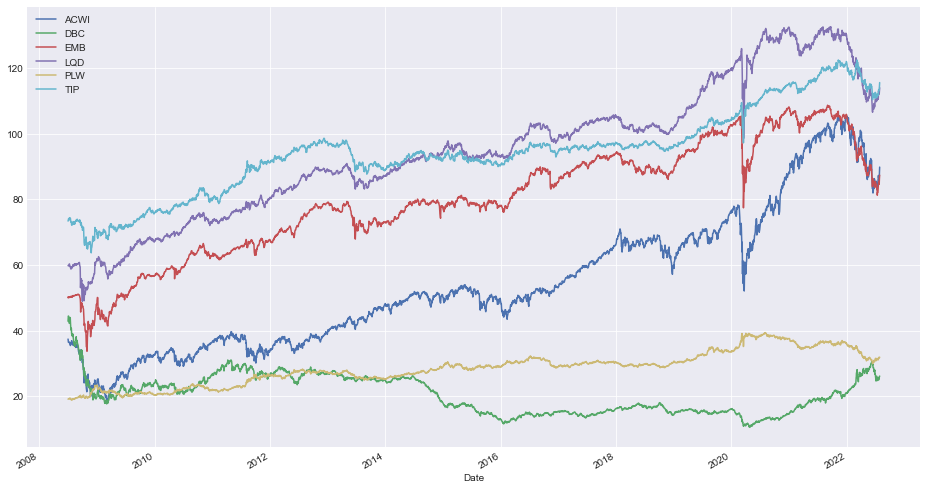

In [8]:
prices.plot(figsize=(16,9))
plt.show()

## Calculate daily returns

In [9]:
daily_rets = prices.pct_change()
daily_rets.head()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2008-06-30       NaN       NaN       NaN       NaN       NaN       NaN
2008-07-01 -0.007689  0.017642 -0.005303 -0.000455  0.001898  0.000252
2008-07-02 -0.015701  0.019092  0.002651 -0.000694 -0.001136  0.006253
2008-07-03 -0.004143 -0.000431 -0.000813 -0.001289  0.002656  0.002597
2008-07-07  0.003952 -0.013572  0.002136  0.004667  0.002270 -0.000463

In [10]:
daily_rets = daily_rets[1:]

In [11]:
daily_rets.head()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2008-07-01 -0.007689  0.017642 -0.005303 -0.000455  0.001898  0.000252
2008-07-02 -0.015701  0.019092  0.002651 -0.000694 -0.001136  0.006253
2008-07-03 -0.004143 -0.000431 -0.000813 -0.001289  0.002656  0.002597
2008-07-07  0.003952 -0.013572  0.002136  0.004667  0.002270 -0.000463
2008-07-08 -0.002901 -0.036253  0.000711  0.005434  0.004530 -0.000741

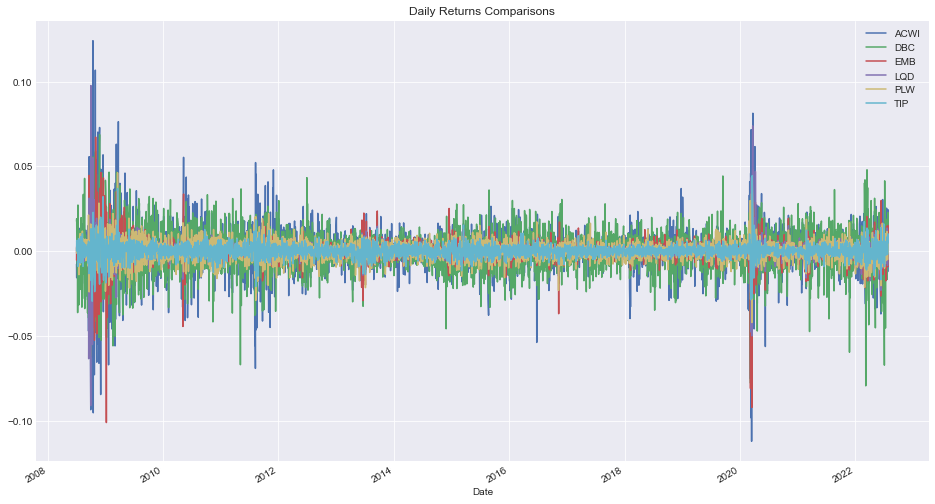

In [12]:
daily_rets.plot(figsize=(16,9), title='Daily Returns Comparisons')
plt.show()

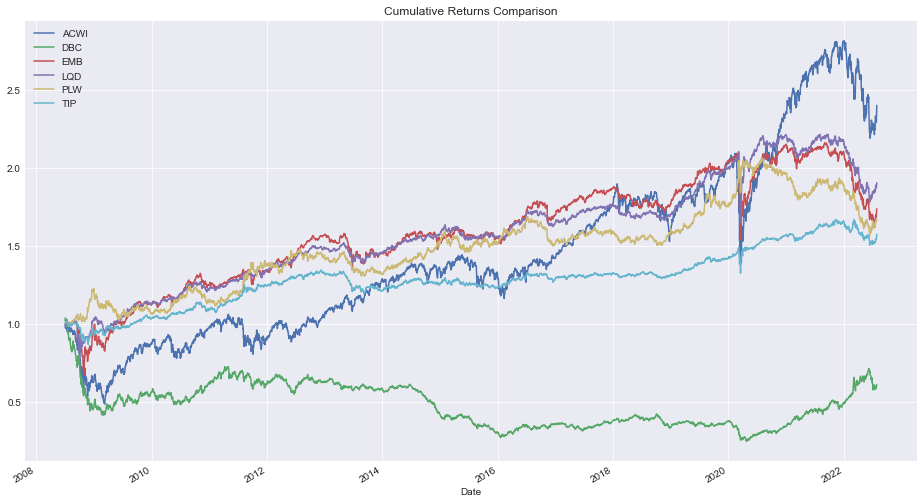

In [13]:
cum_rets = (1 + daily_rets).cumprod()
cum_rets.plot(figsize=(16,9), title='Cumulative Returns Comparison')
plt.show()

## Correlation matrix

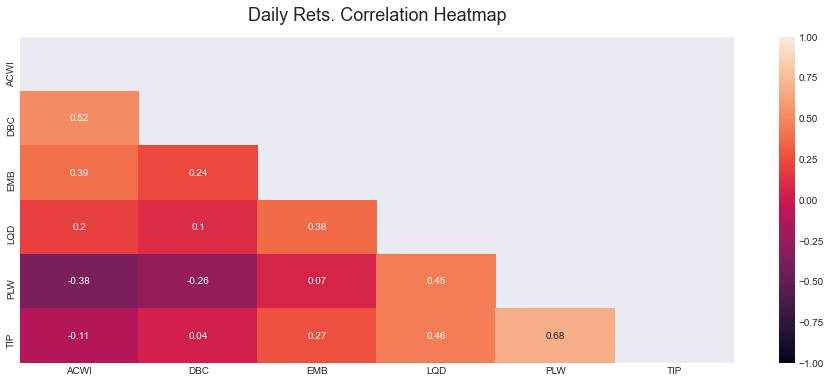

In [14]:
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(daily_rets.corr(), dtype=np.bool))
heatmap = sns.heatmap(daily_rets.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Daily Rets. Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

## Split returns dataset in training and test sets

In [15]:
train = daily_rets[:'2016-06-30']
test = daily_rets['2016-07-01':]

In [16]:
train.tail()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2016-06-24 -0.053842 -0.020235 -0.008475  0.004726  0.017282  0.006258
2016-06-27 -0.018600 -0.001999  0.003027  0.004209  0.014685  0.002937
2016-06-28  0.021768  0.016021  0.007368  0.005507  0.000851  0.003444
2016-06-29  0.018917  0.014455  0.010045 -0.000327 -0.005954 -0.000601
2016-06-30  0.013519 -0.005829  0.004624  0.003515  0.002853  0.001889

In [17]:
test.head()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2016-07-01  0.002134  0.012378  0.003830  0.005237  0.007110  0.007765
2016-07-05 -0.012422 -0.028314  0.002259  0.003413  0.006778  0.001623
2016-07-06  0.001617  0.003973  0.001387  0.001782  0.001402  0.002388
2016-07-07 -0.002332 -0.028364 -0.000346  0.000162 -0.000840 -0.002042
2016-07-08  0.015285  0.010183  0.007970  0.005577  0.001963  0.002217

In [18]:
print(round((len(train.index)/len(daily_rets.index)*100),2))

56.84


In [19]:
print(round((len(test.index)/len(daily_rets.index)*100),2))

43.16


## 60/40 Portfolio

### Building a 60/40 portfolio

In [20]:
sixty_forty = {'60/40':[0.6, 0.4], 
                 'Index': ['ACWI', 'PLW']}

sixty_forty_weights = pd.DataFrame(sixty_forty).set_index('Index')

sixty_forty_weights

60/40
Index       
ACWI     0.6
PLW      0.4

In [21]:
test_60_40 = test[['ACWI', 'PLW']]
test_60_40.head()

ACWI       PLW
Date                          
2016-07-01  0.002134  0.007110
2016-07-05 -0.012422  0.006778
2016-07-06  0.001617  0.001402
2016-07-07 -0.002332 -0.000840
2016-07-08  0.015285  0.001963

### Performance analysis

In [22]:
def portfolio_performance(returns, asset_weight):
    # Portfolio returns
    portfolio_returns = (asset_weight * returns).sum(axis=1)

    # Portfolio returns
    portfolio_cum = (1 + portfolio_returns).cumprod()
    total_return = portfolio_cum.iloc[-1] / portfolio_cum.iloc[0] - 1
    print("Portfolio return : ", round(100 * total_return, 2), "%")

    # Plotting portfolio returns
    plt.figure(figsize=(10, 7))
    plt.plot(portfolio_cum)
    plt.title("Portfolio Return Over Time")
    plt.xlabel("Year-Month")
    plt.ylabel("Cumulative Returns")
    plt.tick_params(axis="x", rotation=45)
    plt.show()

    # Annualised performance
    annualised_performance = (
        (portfolio_cum.iloc[-1] / portfolio_cum.iloc[0])
        ** (252 / len(portfolio_returns))
        - 1
    ) * 100

    # Drawdown calculations
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio_cum.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    running_drawdown = 100 * ((portfolio_cum) / running_max - 1)

    # Calculate the maximum drawdown
    max_drawdown = running_drawdown.min()

    # Calculate the return to max. drawdown ratio
    return_to_MDD_ratio = annualised_performance / max_drawdown

    # Sharpe Ratio
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

    # Plot max drawdown
    plt.figure(figsize=(10, 7))
    plt.title("Drawdown (%)", fontsize=14)
    plt.plot(running_drawdown, color="red")
    plt.xlabel("Year-month", fontsize=12)
    plt.ylabel("Drawdown (%)", fontsize=12)
    plt.fill_between(running_drawdown.index, running_drawdown.values, color="red")
    plt.show()

    # Store the performance metrics
    performance_metrics = pd.DataFrame(
        {
            "Sharpe ratio": round(sharpe, 2),
            "Annualised returns (CAGR)": round(annualised_performance, 2),
            "Maximum drawdown (MDD)": round(max_drawdown, 2),
            "Return-to-MDD ratio": abs(round(return_to_MDD_ratio, 2)),
        },
        index=["Performance Metrics"],
    )
    return performance_metrics

Portfolio return :  47.0 %


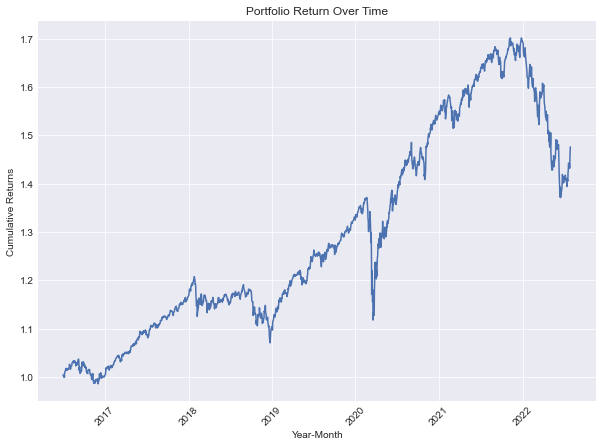

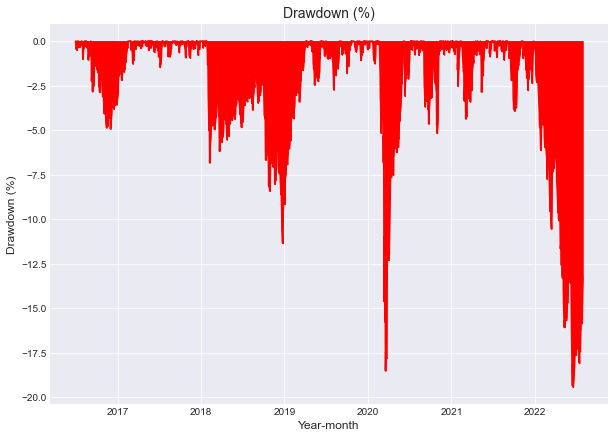

Sharpe ratio  Annualised returns (CAGR)  \
Performance Metrics          0.67                       6.55   

                     Maximum drawdown (MDD)  Return-to-MDD ratio  
Performance Metrics                  -19.43                 0.34

In [23]:
# Returns data in testing period
returns_test_60_40 = test_60_40.copy()

# Performance metrics
performance_metrics_60_40 = portfolio_performance(returns_test_60_40, sixty_forty_weights['60/40'])
performance_metrics_60_40

In [24]:
sixy_forty_rets = (sixty_forty_weights['60/40'] * returns_test_60_40).sum(axis=1)

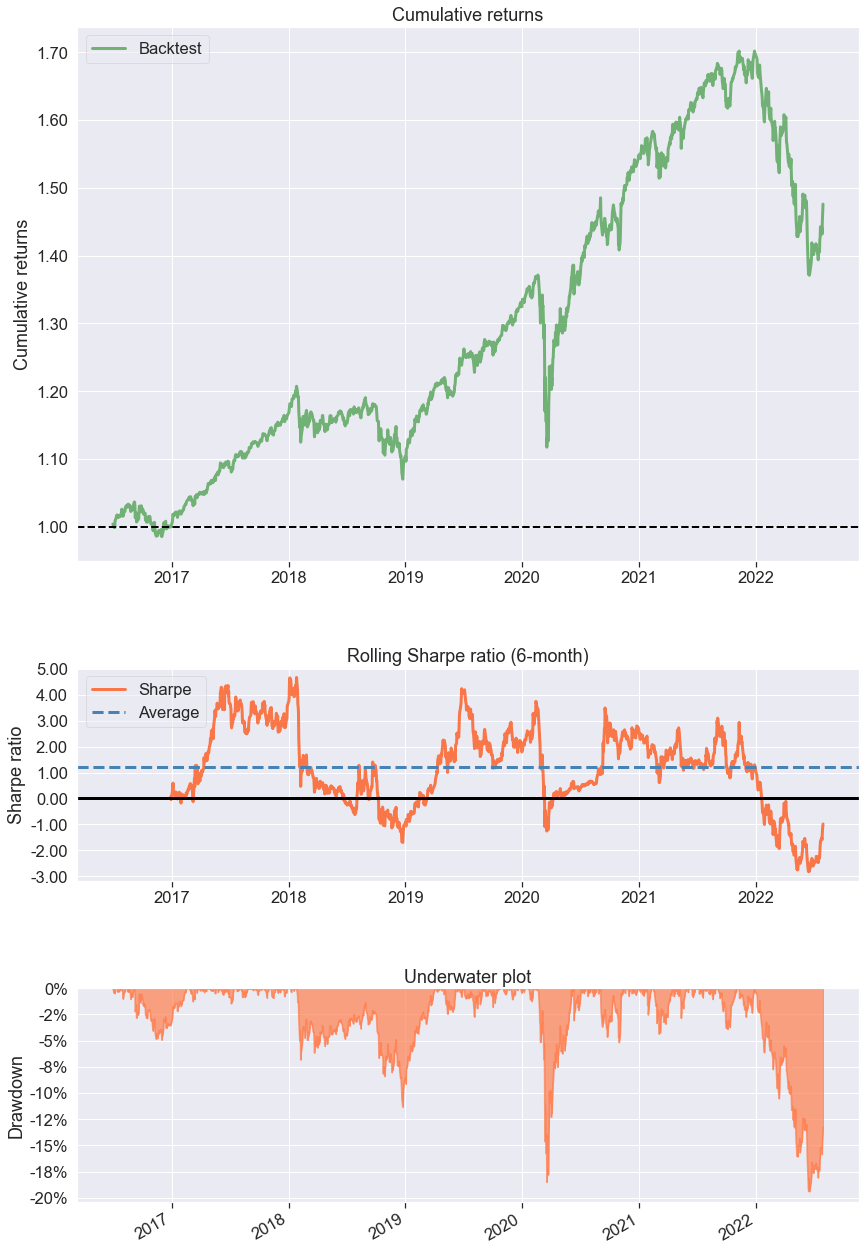

In [25]:
pf.create_simple_tear_sheet(sixy_forty_rets, benchmark_rets=None, set_context=True)

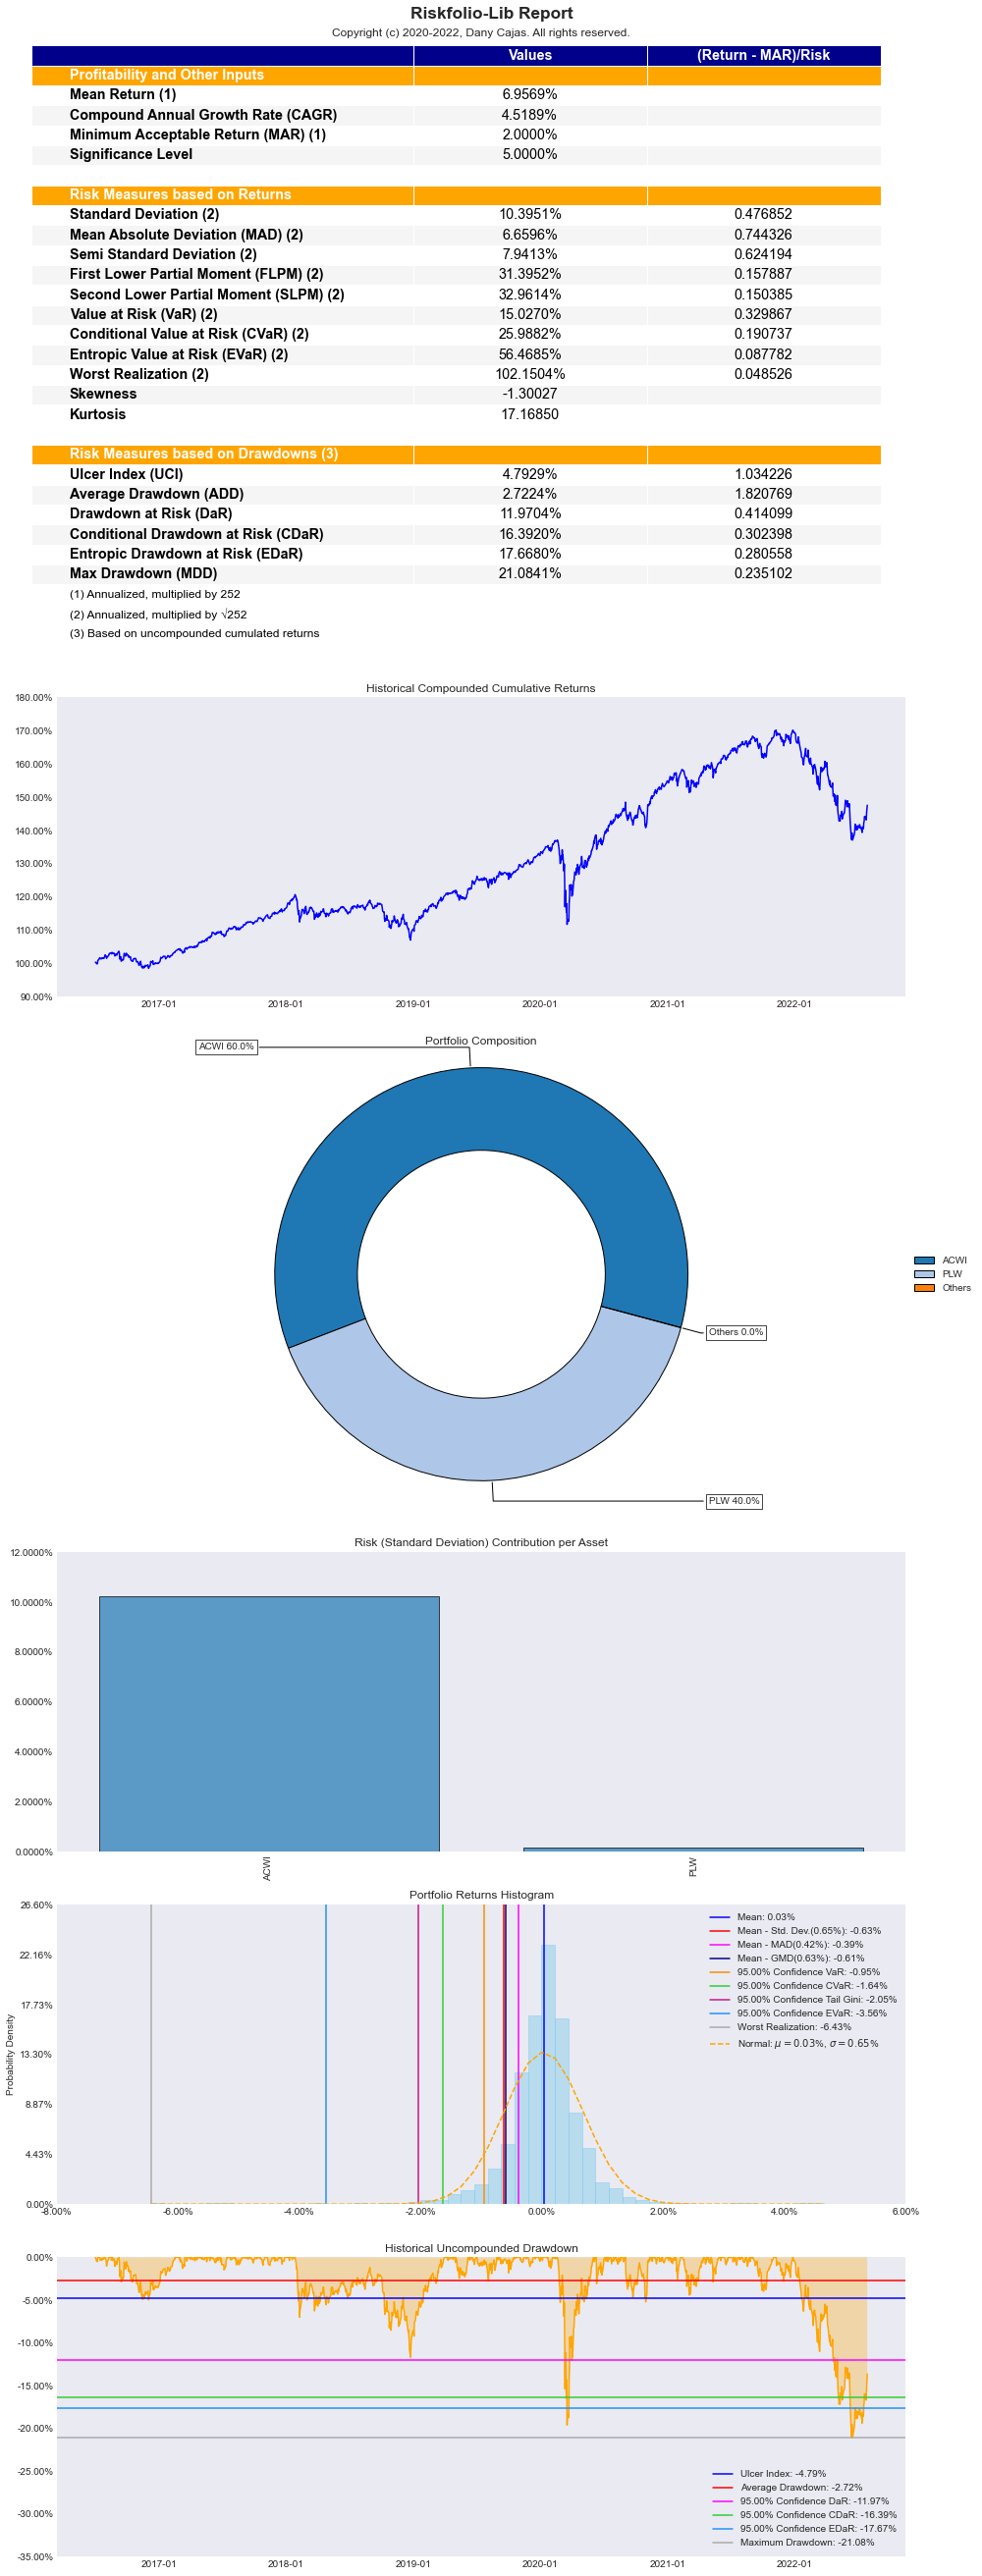

In [26]:
rm = 'MV' 

ax = rp.jupyter_report(returns_test_60_40,
                       sixty_forty_weights,
                       rm=rm,
                       rf=0.02,
                       alpha=0.05,
                       others=0.05,
                       nrow=25,
                       height=6,
                       width=14,
                       t_factor=252,
                       ini_days=1,
                       days_per_year=252,
                       bins=50,
                       )

## Mean-Variance Optimization

### Expected returns and covariance matrix

In [27]:
prices_mvo = prices[prices.index.isin(train.index)]
prices_mvo.tail()

ACWI        DBC        EMB         LQD        PLW        TIP
Date                                                                         
2016-06-24  48.262455  14.583916  84.473396  100.262642  31.304689  95.467468
2016-06-27  47.364750  14.554767  84.729126  100.684624  31.764385  95.747841
2016-06-28  48.395771  14.787954  85.353416  101.239067  31.791422  96.077637
2016-06-29  49.311253  15.001708  86.210831  101.205948  31.602137  96.019913
2016-06-30  49.977867  14.914264  86.609482  101.561737  31.692287  96.201324

In [28]:
# Calculate expected returns from prices
mu = expected_returns.capm_return(prices_mvo)
mu

ACWI    0.045589
DBC     0.042250
EMB     0.029580
LQD     0.027037
PLW     0.020280
TIP     0.023120
Name: mkt, dtype: float64

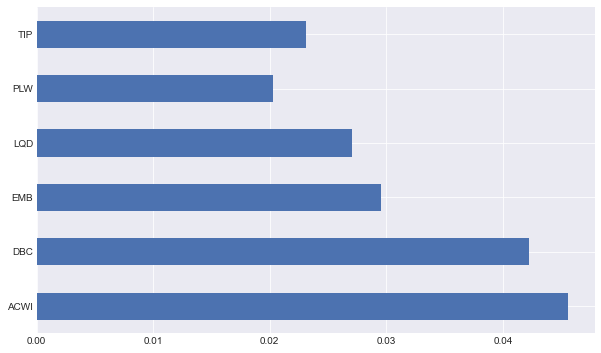

In [29]:
mu.plot.barh(figsize=(10,6));

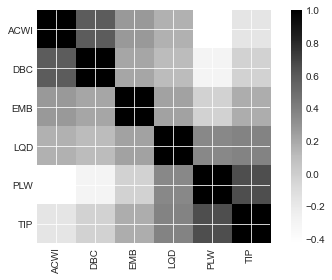

In [30]:
# Ledoit - Wolf Covariance Matrix
S = risk_models.CovarianceShrinkage(prices_mvo).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

### Efficient Frontier

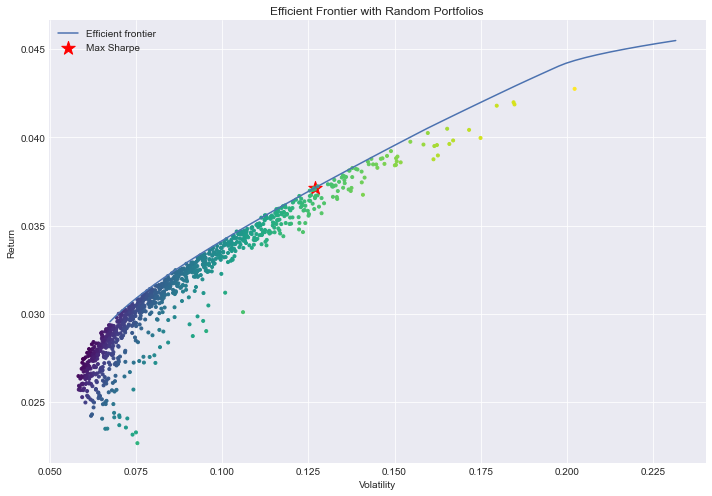

In [131]:
def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
    ef.add_objective(objective_functions.L2_reg, gamma=0.1)

    fig, ax = plt.subplots(figsize=(10,7))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=200, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

### Running MVO for max Sharpe ratio

In [33]:
ef = EfficientFrontier(mu, S, weight_bounds=(0,1))  # weight_bounds automatically set to (0, 1)

ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter

ef.max_sharpe()
weights_mvo = ef.clean_weights()

In [34]:
weights_mvo

OrderedDict([('ACWI', 0.31753),
             ('DBC', 0.2885),
             ('EMB', 0.15345),
             ('LQD', 0.12536),
             ('PLW', 0.04513),
             ('TIP', 0.07003)])

In [35]:
weights_df = pd.DataFrame(weights_mvo, columns=weights_mvo.keys(), index=test.columns)
weights_df_T = weights_df.T
weights_df_T = pd.DataFrame(weights_df_T.iloc[:,0])
weights_df_T.rename(columns={weights_df_T.columns[0]: 'MVO'}, inplace=True)
weights_df_T

MVO
ACWI  0.31753
DBC   0.28850
EMB   0.15345
LQD   0.12536
PLW   0.04513
TIP   0.07003

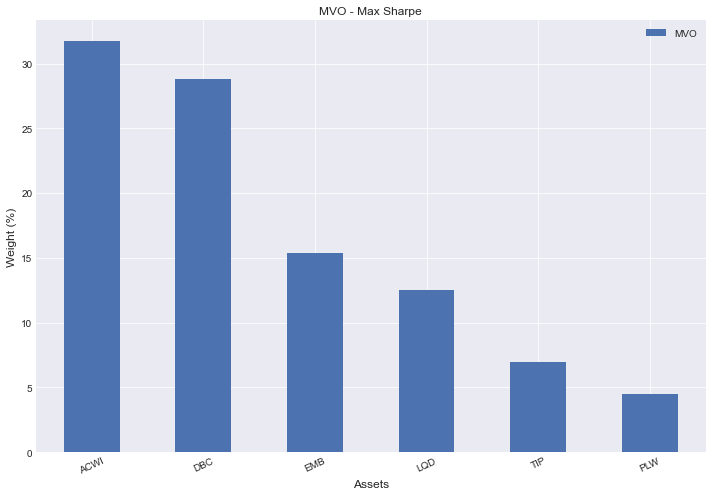

In [36]:
# Percentage weights
percentage_weights_mvo = (weights_df_T * 100).sort_values(by='MVO', ascending=False)

# Bar plot
percentage_weights_mvo.plot.bar(
    figsize=(10, 7), title='MVO - Max Sharpe', rot=25)

# Set lables for the plot
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Weight (%)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### Performance analysis

Portfolio return :  50.16 %


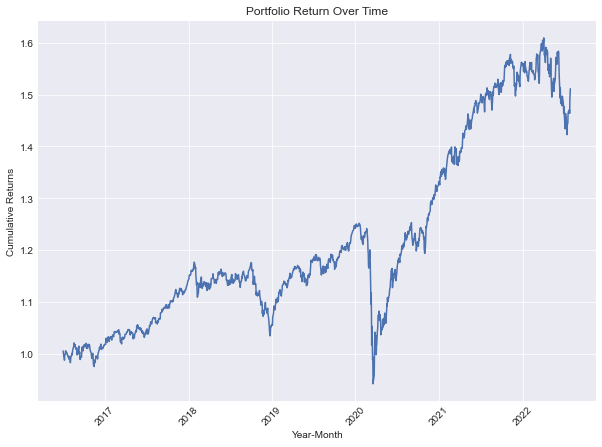

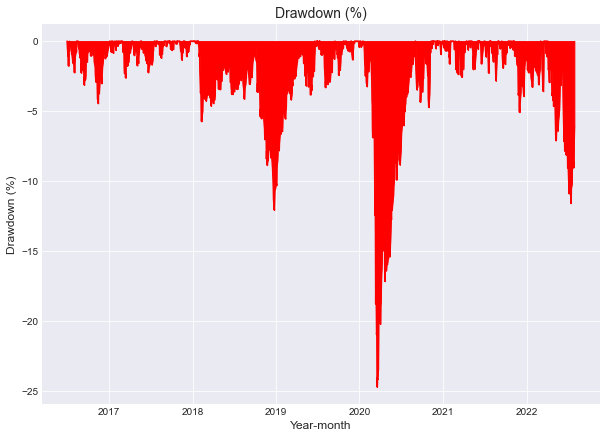

Sharpe ratio  Annualised returns (CAGR)  \
Performance Metrics           0.7                       6.93   

                     Maximum drawdown (MDD)  Return-to-MDD ratio  
Performance Metrics                  -24.68                 0.28

In [37]:
# Returns data in testing period
returns_test = test.copy()

# Performance metrics
performance_metrics_MVO = portfolio_performance(returns_test, weights_df_T['MVO'])
performance_metrics_MVO

In [38]:
# Portfolio returns
mvo_returns = (weights_df_T['MVO'] * returns_test).sum(axis=1)
bmk_rets = (sixty_forty_weights['60/40'] * returns_test_60_40).sum(axis=1)

In [39]:
bmk_rets = pd.DataFrame(bmk_rets, columns=['60/40 Portfolio'])
bmk_rets = bmk_rets.iloc[:,0]

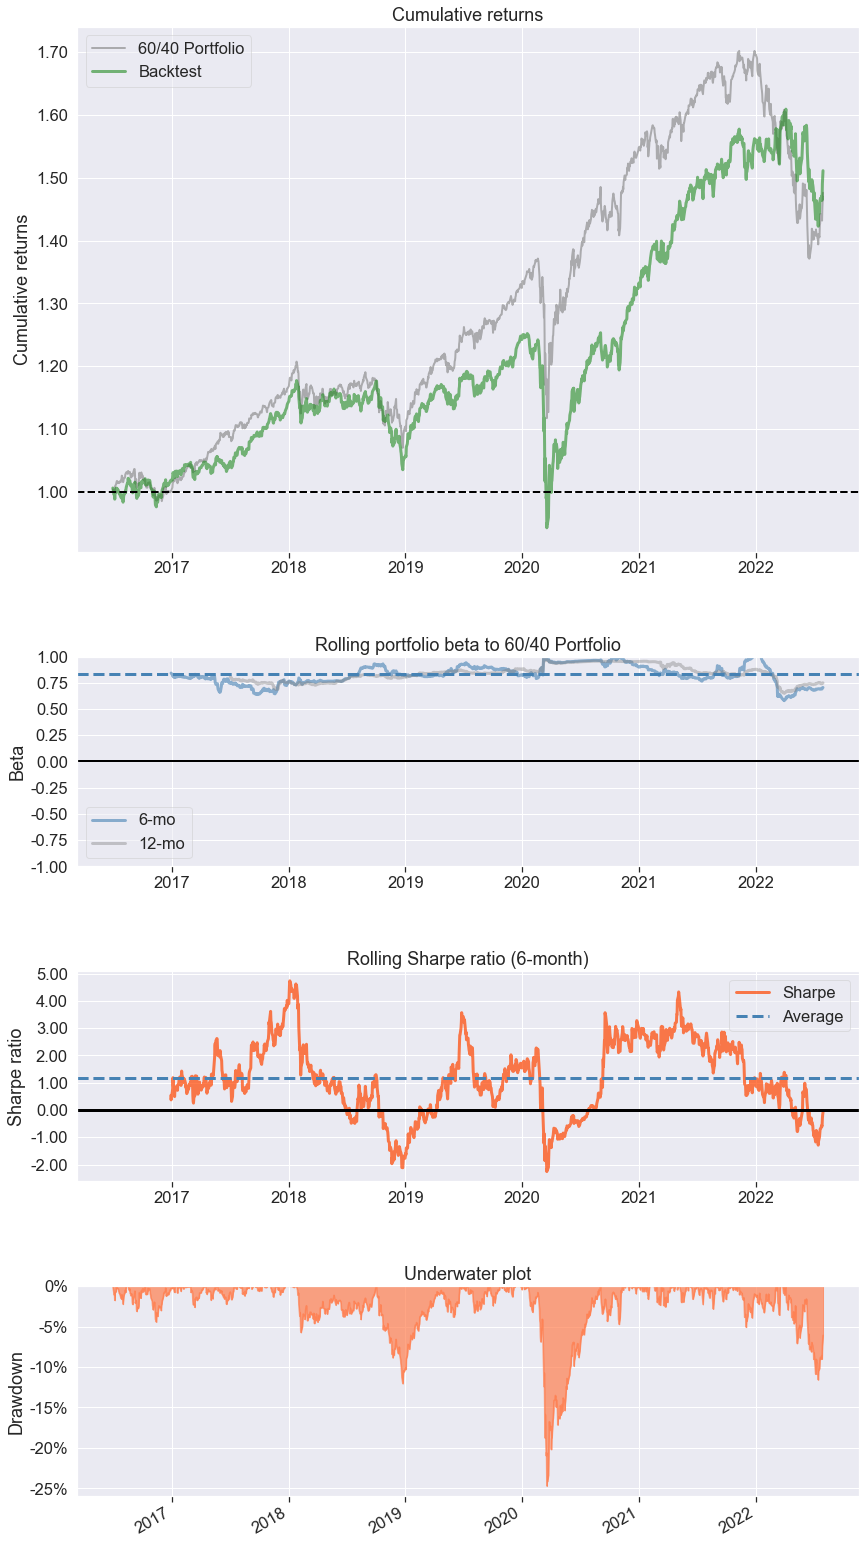

In [40]:
pf.create_simple_tear_sheet(mvo_returns, benchmark_rets=bmk_rets, set_context=True)

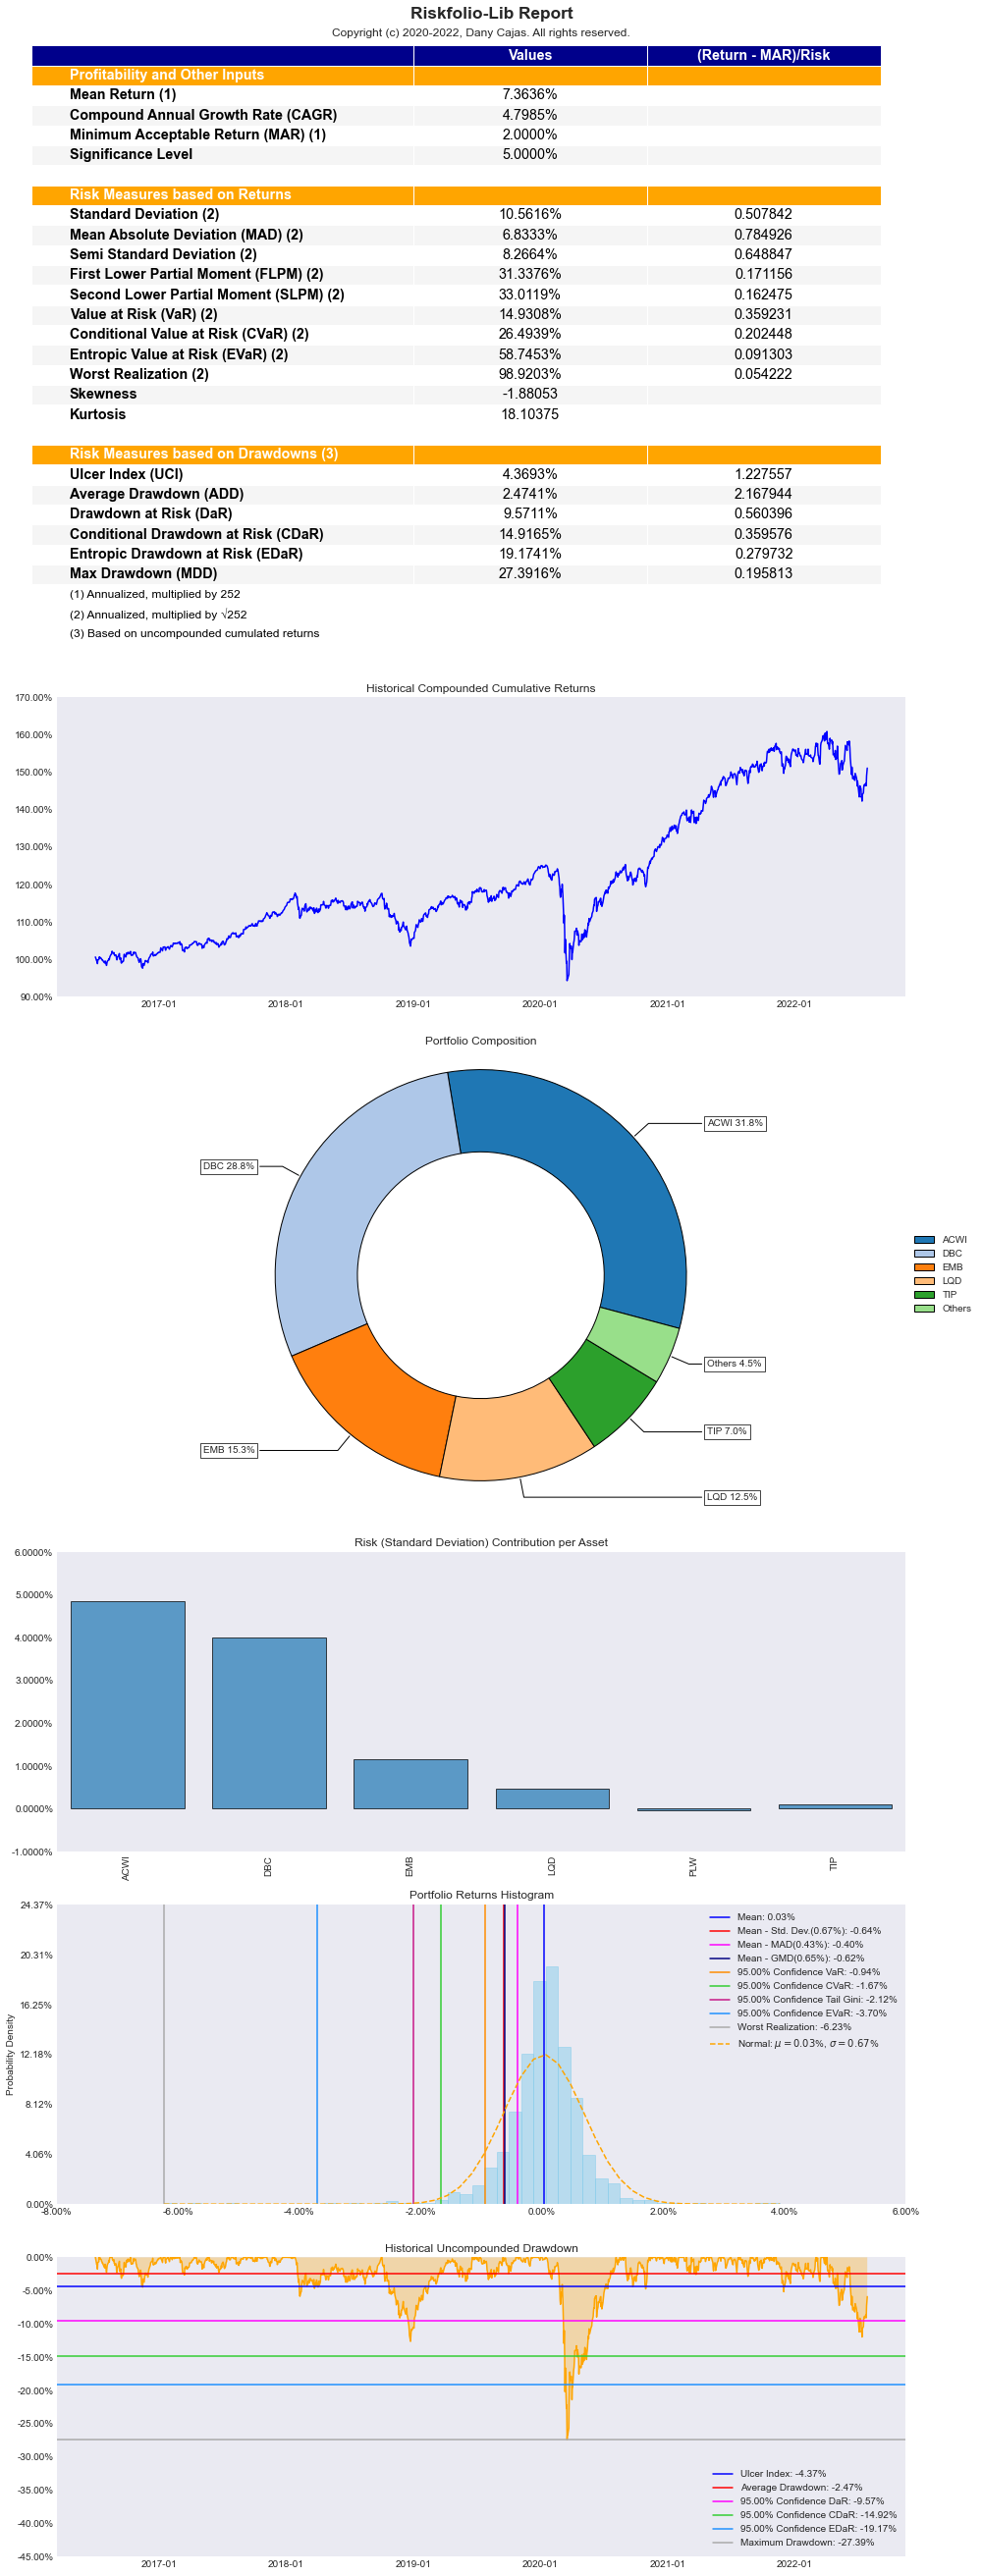

In [41]:
rm = 'MV' 

ax = rp.jupyter_report(returns_test,
                       weights_df_T,
                       rm=rm,
                       rf=0.02,
                       alpha=0.05,
                       others=0.05,
                       nrow=25,
                       height=6,
                       width=14,
                       t_factor=252,
                       ini_days=1,
                       days_per_year=252,
                       bins=50,
                       )

## All Weather

### Calculating weights for "Rising Growth" sub-portfolio

In [42]:
rets_rg = train[['ACWI', 'DBC', 'EMB', 'LQD']]
rets_rg.head()

ACWI       DBC       EMB       LQD
Date                                              
2008-07-01 -0.007689  0.017642 -0.005303 -0.000455
2008-07-02 -0.015701  0.019092  0.002651 -0.000694
2008-07-03 -0.004143 -0.000431 -0.000813 -0.001289
2008-07-07  0.003952 -0.013572  0.002136  0.004667
2008-07-08 -0.002901 -0.036253  0.000711  0.005434

In [43]:
# Building the portfolio object
port_rg = rp.Portfolio(returns=rets_rg)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port_rg.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.02 # Risk free rate
b = None # Risk contribution constraints vector
w_rg = port_rg.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rg.T)

ACWI       DBC      EMB       LQD
weights  0.133514  0.160721  0.29415  0.411614

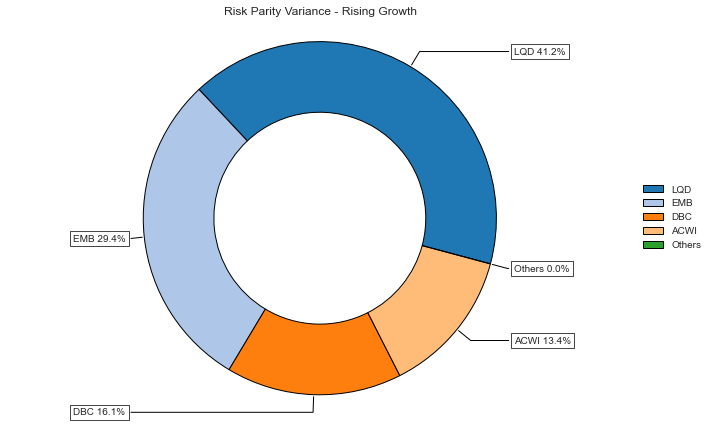

In [44]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_rg,
                 title='Risk Parity Variance - Rising Growth',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

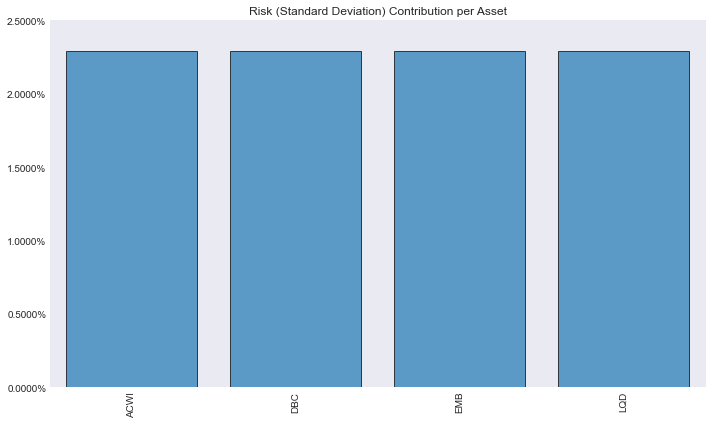

In [45]:
# Plotting the risk contribution per asset

mu_rg = rets_rg.mean()
cov_rg = rets_rg.cov() # Covariance matrix
returns_rg = rets_rg # Returns of the assets

ax_rg = rp.plot_risk_con(w=w_rg,
                      cov=cov_rg,
                      returns=returns_rg,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### Calculating weights for "Rising Inflation" sub-portfolio

In [46]:
rets_ri = train[['DBC', 'EMB', 'TIP']]
rets_ri.head()

DBC       EMB       TIP
Date                                    
2008-07-01  0.017642 -0.005303  0.000252
2008-07-02  0.019092  0.002651  0.006253
2008-07-03 -0.000431 -0.000813  0.002597
2008-07-07 -0.013572  0.002136 -0.000463
2008-07-08 -0.036253  0.000711 -0.000741

In [47]:
# Building the portfolio object
port_ri = rp.Portfolio(returns=rets_ri)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port_ri.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.02 # Risk free rate
b = None # Risk contribution constraints vector
w_ri = port_ri.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_ri.T)

DBC       EMB       TIP
weights  0.177508  0.274901  0.547591

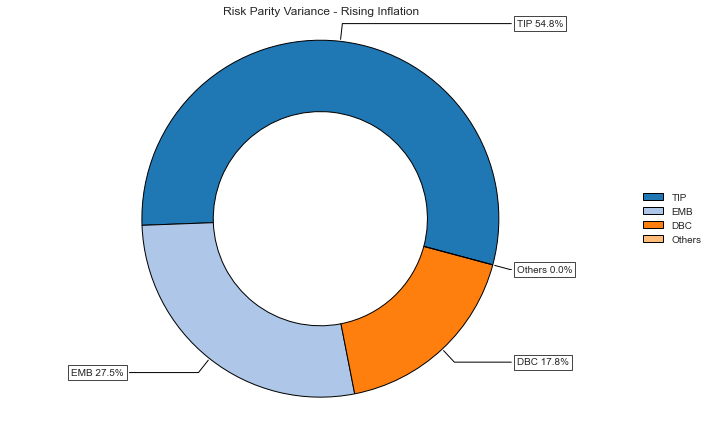

In [48]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_ri,
                 title='Risk Parity Variance - Rising Inflation',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

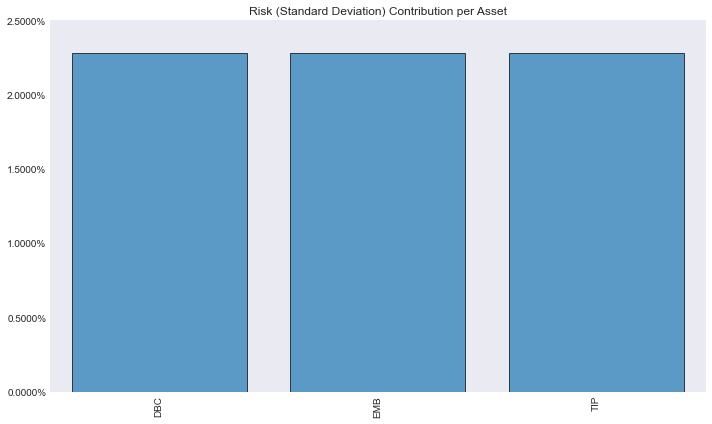

In [49]:
# Plotting the risk contribution per asset

mu_ri = rets_ri.mean()
cov_ri = rets_ri.cov() # Covariance matrix
returns_ri = rets_ri # Returns of the assets

ax_rg = rp.plot_risk_con(w=w_ri,
                      cov=cov_ri,
                      returns=returns_ri,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### Calculating weights for "Falling Growth" sub-portfolio

In [50]:
rets_fg = train[['PLW', 'TIP']]
rets_fg.head()

PLW       TIP
Date                          
2008-07-01  0.001898  0.000252
2008-07-02 -0.001136  0.006253
2008-07-03  0.002656  0.002597
2008-07-07  0.002270 -0.000463
2008-07-08  0.004530 -0.000741

In [51]:
# Building the portfolio object
port_fg = rp.Portfolio(returns=rets_fg)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port_fg.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.02 # Risk free rate
b = None # Risk contribution constraints vector
w_fg = port_fg.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_fg.T)

PLW       TIP
weights  0.405912  0.594088

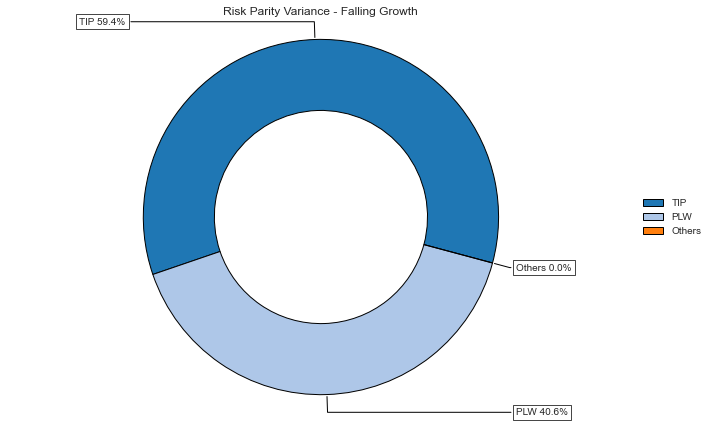

In [52]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_fg,
                 title='Risk Parity Variance - Falling Growth',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

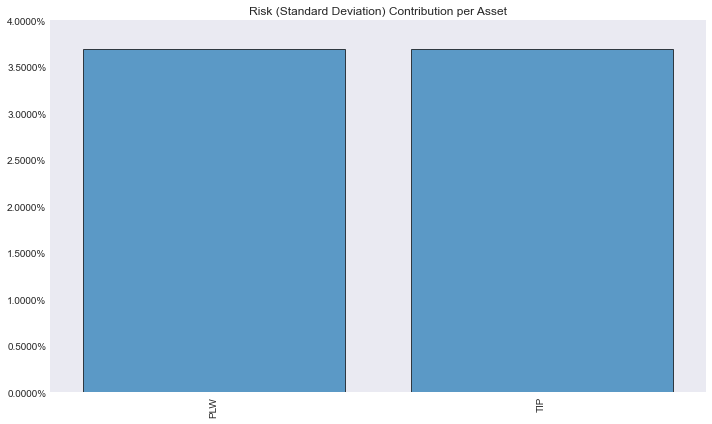

In [53]:
# Plotting the risk contribution per asset

mu_fg = rets_fg.mean()
cov_fg = rets_fg.cov() # Covariance matrix
returns_fg = rets_fg # Returns of the assets

ax_rg = rp.plot_risk_con(w=w_fg,
                      cov=cov_fg,
                      returns=returns_fg,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### Calculating weights for "Falling Inflation" sub-portfolio

In [54]:
rets_fi = train[['ACWI', 'PLW']]
rets_fi.head()

ACWI       PLW
Date                          
2008-07-01 -0.007689  0.001898
2008-07-02 -0.015701 -0.001136
2008-07-03 -0.004143  0.002656
2008-07-07  0.003952  0.002270
2008-07-08 -0.002901  0.004530

In [55]:
# Building the portfolio object
port_fi = rp.Portfolio(returns=rets_fi)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port_fi.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.02 # Risk free rate
b = None # Risk contribution constraints vector
w_fi = port_fi.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_fi.T)

ACWI       PLW
weights  0.295917  0.704083

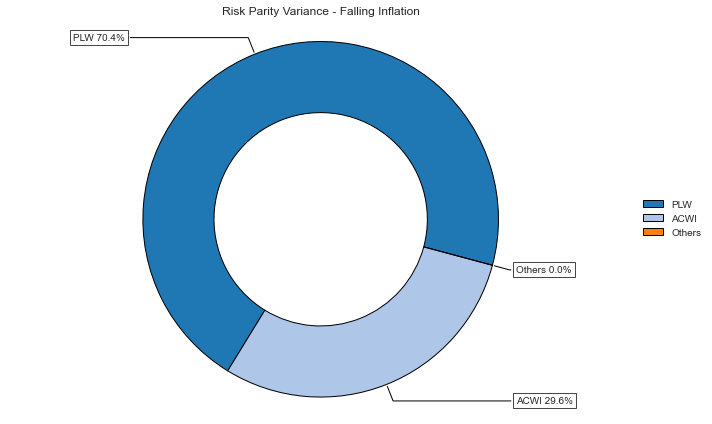

In [56]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w_fi,
                 title='Risk Parity Variance - Falling Inflation',
                 others=0.05,
                 nrow=25,
                 cmap = "tab20",
                 height=6,
                 width=10,
                 ax=None)

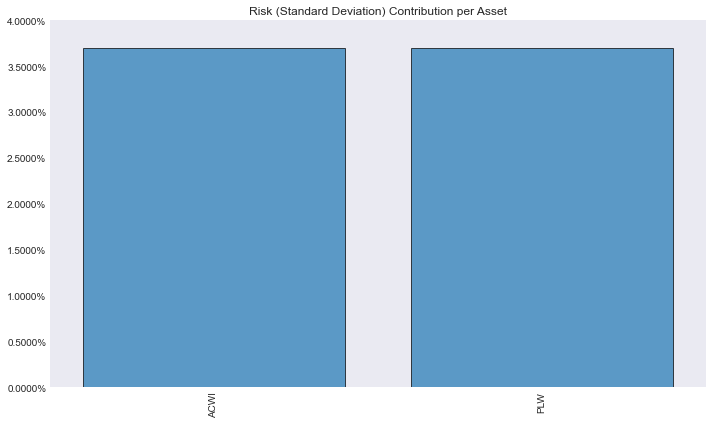

In [57]:
# Plotting the risk contribution per asset

mu_fi = rets_fi.mean()
cov_fi = rets_fi.cov() # Covariance matrix
returns_fi = rets_fi # Returns of the assets

ax_rg = rp.plot_risk_con(w=w_fi,
                      cov=cov_fi,
                      returns=returns_fi,
                      rm=rm,
                      rf=rf,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

### Attributing weights

In [58]:
# Calculating pro-rated sub-portfolios weights (i.e. 25% each)
w_rg_25 = w_rg.mul(0.25, axis=0)
w_rg_25

weights
ACWI  0.033379
DBC   0.040180
EMB   0.073538
LQD   0.102904

In [59]:
# Calculating pro-rated sub-portfolios weights (i.e. 25% each)
w_ri_25 = w_ri.mul(0.25, axis=0)
w_ri_25

weights
DBC  0.044377
EMB  0.068725
TIP  0.136898

In [60]:
# Calculating pro-rated sub-portfolios weights (i.e. 25% each)
w_fg_25 = w_fg.mul(0.25, axis=0)
w_fg_25

weights
PLW  0.101478
TIP  0.148522

In [61]:
# Calculating pro-rated sub-portfolios weights (i.e. 25% each)
w_fi_25 = w_fi.mul(0.25, axis=0)
w_fi_25

weights
ACWI  0.073979
PLW   0.176021

In [62]:
aw_weights = pd.concat([w_rg_25, w_ri_25, w_fg_25, w_fi_25], axis=1)
aw_weights['All_Weather'] = aw_weights.sum(axis=1)
aw_weights = pd.DataFrame(aw_weights['All_Weather'])
aw_weights

All_Weather
ACWI     0.107358
DBC      0.084557
EMB      0.142263
LQD      0.102904
TIP      0.285420
PLW      0.277499

In [63]:
print(round(aw_weights['All_Weather'].sum(axis=0), 2))

1.0


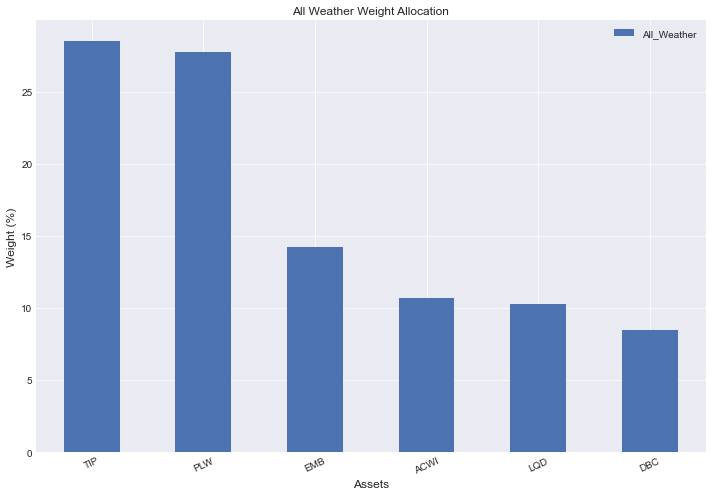

In [64]:
# Percentage weights
percentage_weights_aw = (aw_weights * 100).sort_values(by='All_Weather', ascending=False)

# Bar plot
percentage_weights_aw.plot.bar(
    figsize=(10, 7), title='All Weather Weight Allocation', rot=25)

# Set lables for the plot
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Weight (%)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

### Weights comparison

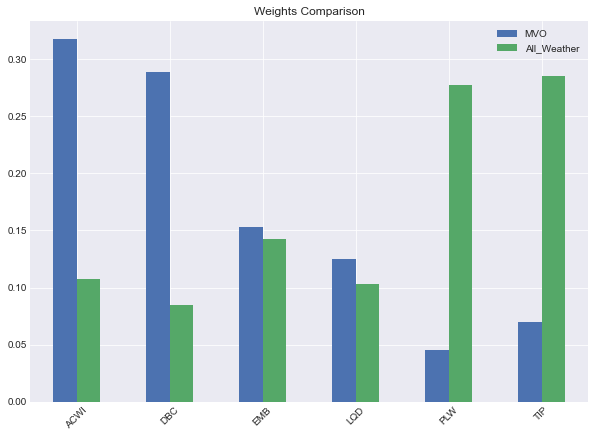

In [65]:
weights_df_T.merge(aw_weights, left_index=True, right_index=True).plot(
    kind='bar', grid=True, figsize=(10, 7), rot=45, title='Weights Comparison');

### Performance analysis

Portfolio return :  21.5 %


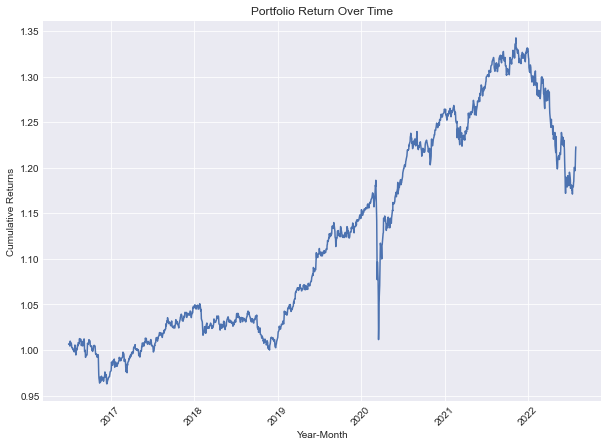

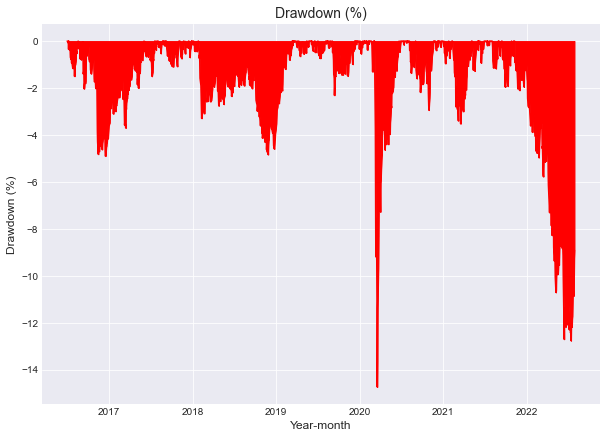

Sharpe ratio  Annualised returns (CAGR)  \
Performance Metrics          0.57                       3.26   

                     Maximum drawdown (MDD)  Return-to-MDD ratio  
Performance Metrics                  -14.74                 0.22

In [66]:
# Performance metrics
performance_metrics = portfolio_performance(returns_test, aw_weights['All_Weather'])
performance_metrics

In [67]:
# Portfolio returns
aw_returns = (aw_weights['All_Weather'] * returns_test).sum(axis=1)
#bmk_rets = (sixty_forty_weights['60/40'] * returns_test_60_40).sum(axis=1)

In [68]:
#bmk_rets = pd.DataFrame(bmk_rets, columns=['60/40 Portfolio'])
#bmk_rets = bmk_rets.iloc[:,0]

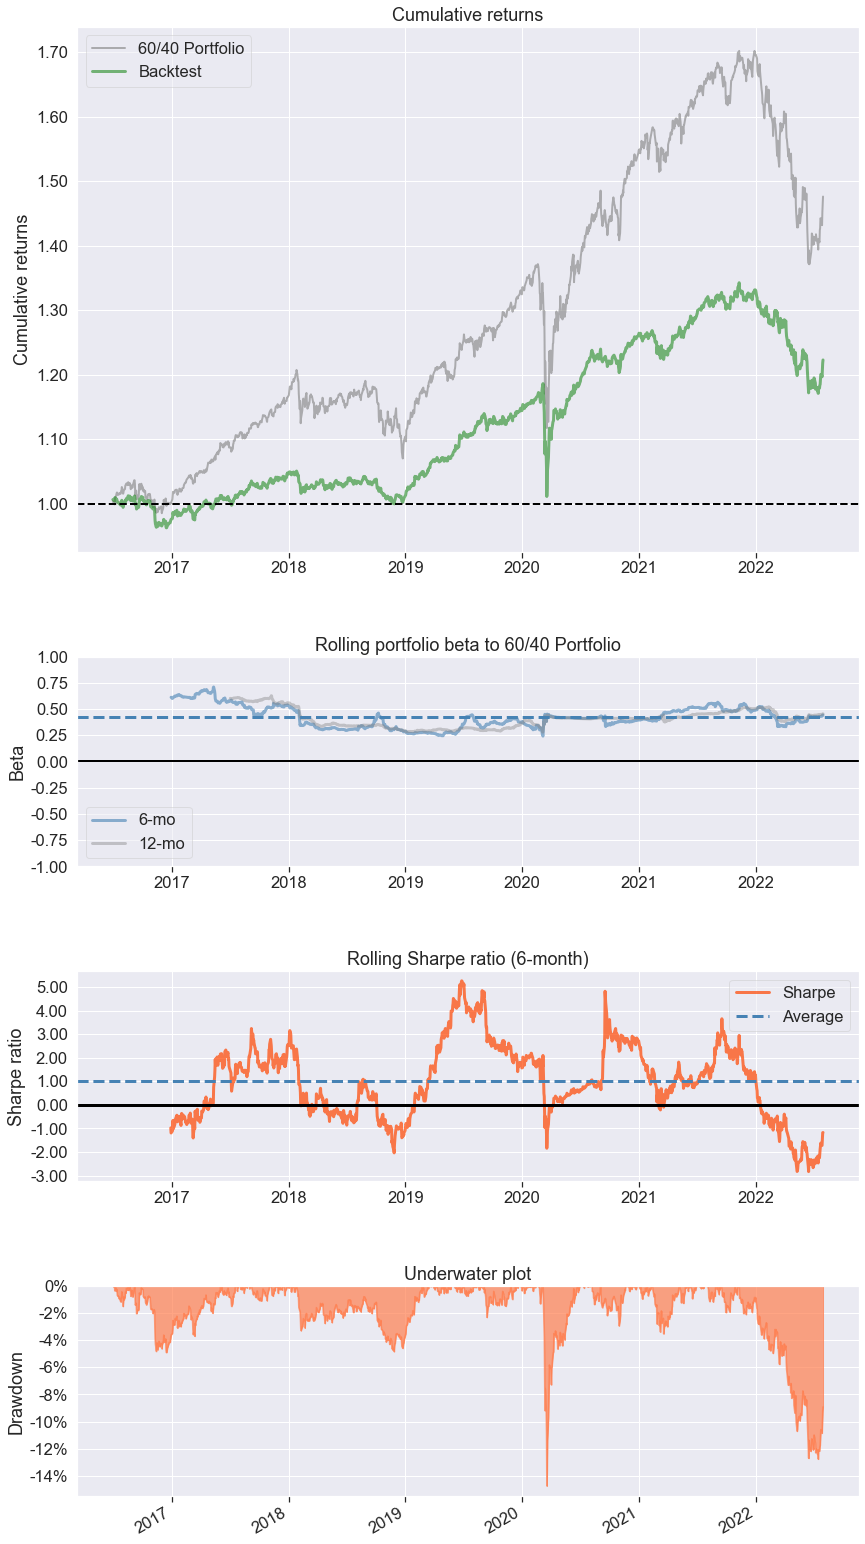

In [69]:
pf.create_simple_tear_sheet(aw_returns, benchmark_rets=bmk_rets, set_context=True)

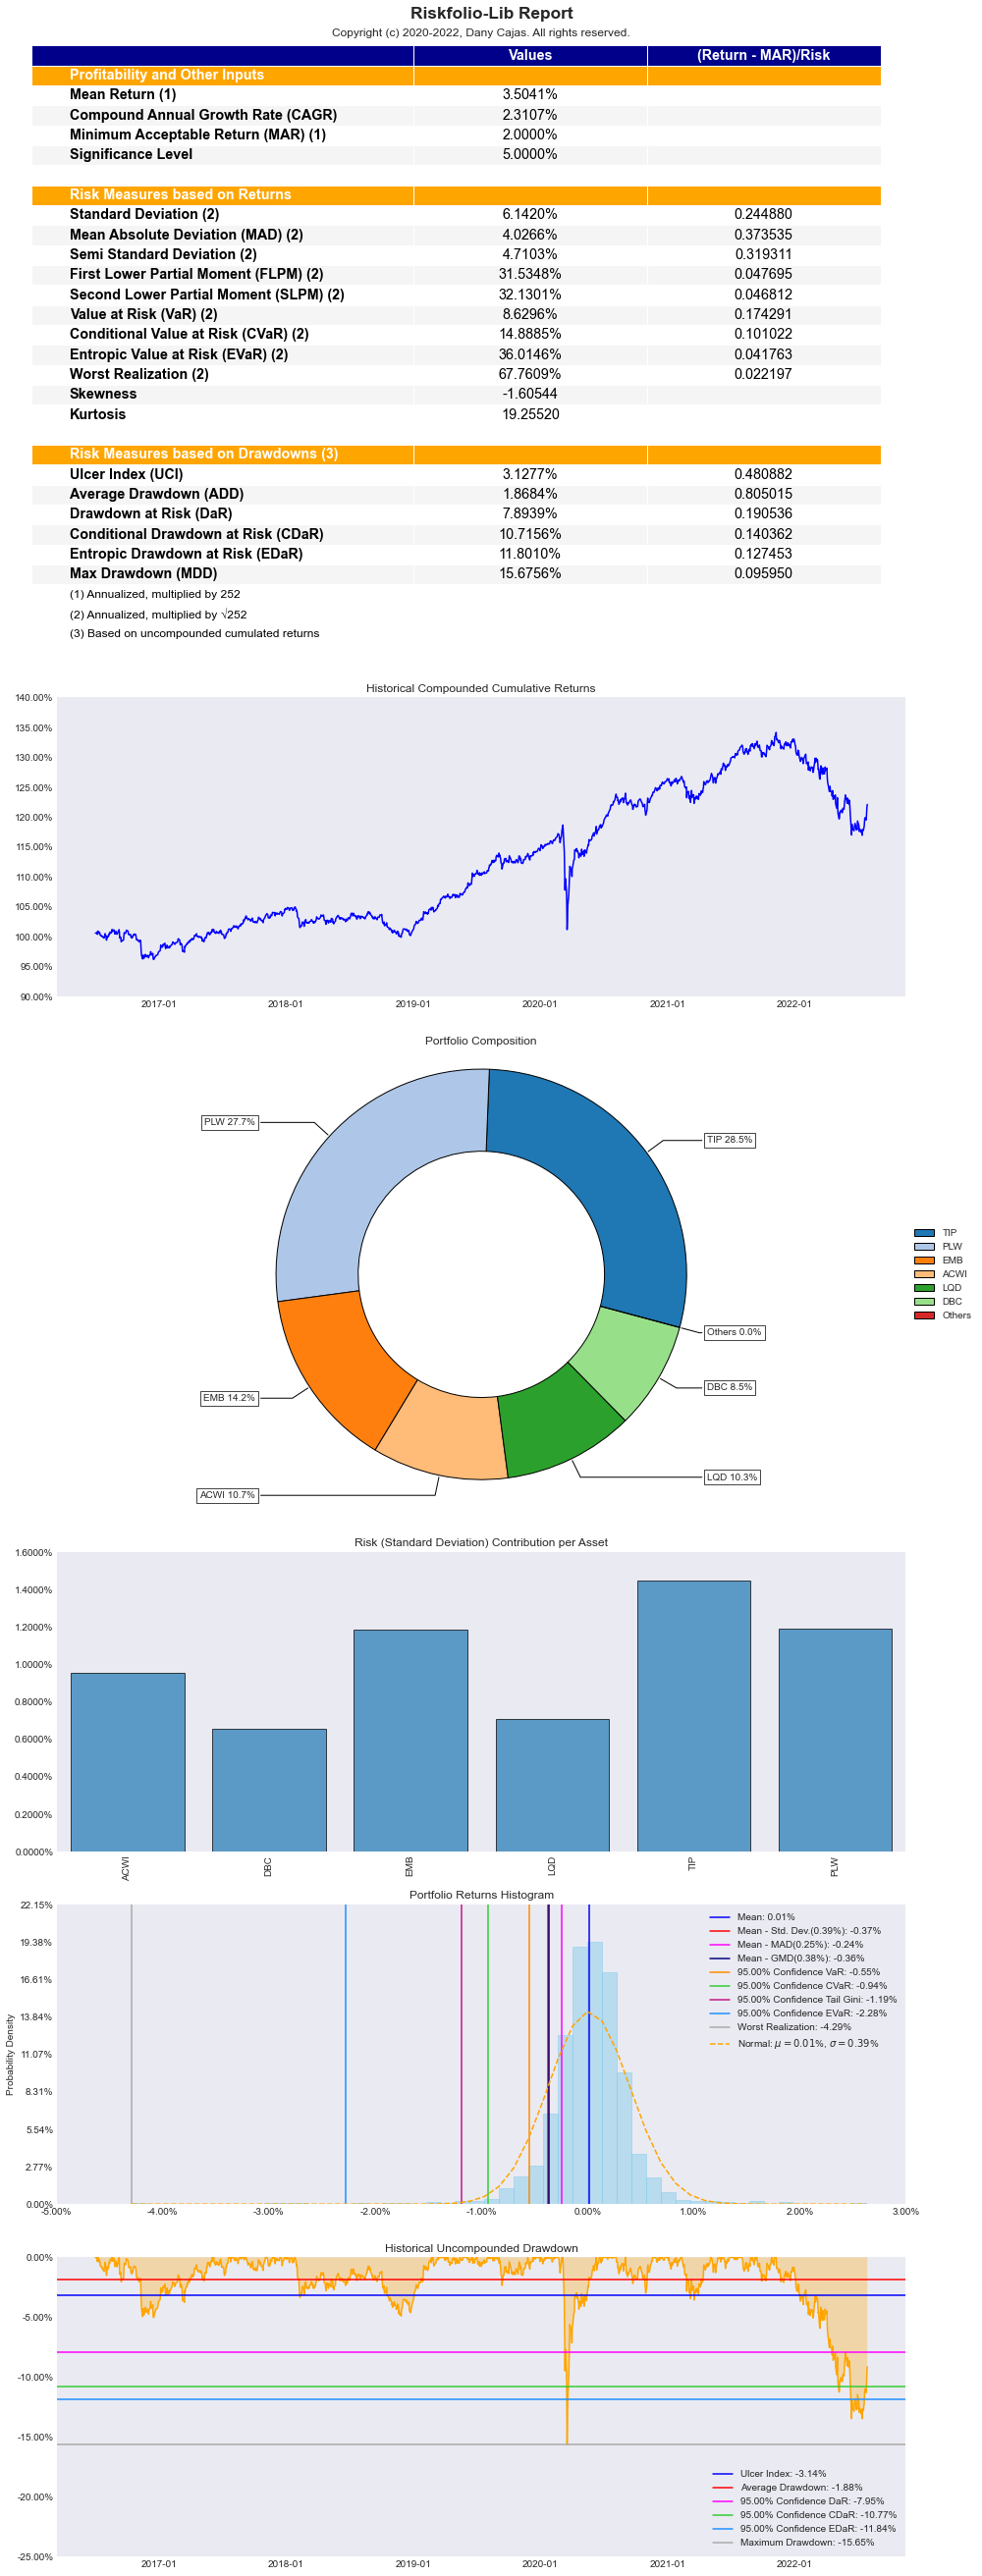

In [70]:
rm = 'MV' 

ax = rp.jupyter_report(returns_test,
                       aw_weights,
                       rm=rm,
                       rf=0.02,
                       alpha=0.05,
                       others=0.05,
                       nrow=25,
                       height=6,
                       width=14,
                       t_factor=252,
                       ini_days=1,
                       days_per_year=252,
                       bins=50,
                       )

## Hierarchical Risk Parity

### Fetch data for growth and inflation

In [71]:
gdp_world = pd.DataFrame(fred.get_series('NYGDPMKTPCDWLD', 
                            observation_start='2009-01-01', 
                            observation_end='2016-01-01', 
                            units='pc1'), columns=['gdp_world'])
cpi_world = pd.DataFrame(fred.get_series('FPCPITOTLZGWLD', 
                            observation_start='2009-01-01', 
                            observation_end='2016-01-01', 
                            units='pc1'), columns=['cpi_world'])

In [72]:
gdp_world.head()

gdp_world
2009-01-01   -5.16906
2010-01-01    9.51657
2011-01-01   10.89814
2012-01-01    2.21286
2013-01-01    2.80724

In [73]:
cpi_world.head()

cpi_world
2009-01-01  -67.20383
2010-01-01   14.25385
2011-01-01   43.74798
2012-01-01  -22.74947
2013-01-01  -29.64241

### Calculate annual returns of assets

First, we need to fetch monthly prices that will be used to calculate annual returns used in our correlation matrix. Then, we will use those results for the HRP weights. 

In [74]:
prices_mo = pd.DataFrame(yf.download(tickers, start='2008-05-31', interval='1mo')['Adj Close'])

[*********************100%***********************]  6 of 6 completed


In [75]:
prices_mo.head()

ACWI        DBC        EMB        LQD        PLW        TIP
Date                                                                        
2008-06-01  37.393303  42.833363  50.016407  59.548817  19.021227  72.808334
2008-06-02        NaN        NaN        NaN        NaN        NaN        NaN
2008-06-13        NaN        NaN        NaN        NaN        NaN        NaN
2008-07-01  36.212952  38.643768  50.446720  59.799442  19.106634  72.437111
2008-07-15        NaN        NaN        NaN        NaN        NaN        NaN

In [76]:
prices_mo.tail()

ACWI        DBC        EMB         LQD        PLW         TIP
Date                                                                          
2022-07-01  89.820000  26.110001  86.983704  113.708153  31.820002  115.024658
2022-07-18        NaN        NaN        NaN         NaN        NaN         NaN
2022-08-01  85.900002  25.719999  84.653915  108.703590  30.638670  111.374207
2022-09-01  84.949997  25.340000  84.768806  108.088448  30.510000  110.862572
2022-09-02  84.949997  25.340000  85.080002  108.389999  30.510000  112.279999

In [77]:
prices_mo.dropna(inplace=True)

In [78]:
prices_mo.tail()

ACWI        DBC        EMB         LQD        PLW         TIP
Date                                                                          
2022-06-01  83.116905  26.639999  84.005959  108.902824  31.036732  109.548088
2022-07-01  89.820000  26.110001  86.983704  113.708153  31.820002  115.024658
2022-08-01  85.900002  25.719999  84.653915  108.703590  30.638670  111.374207
2022-09-01  84.949997  25.340000  84.768806  108.088448  30.510000  110.862572
2022-09-02  84.949997  25.340000  85.080002  108.389999  30.510000  112.279999

In [79]:
prices_mo = prices_mo[:-2]

In [80]:
prices_mo.tail()

ACWI        DBC        EMB         LQD        PLW         TIP
Date                                                                          
2022-04-01  90.884659  27.530001  88.772774  110.960640  31.529982  114.791725
2022-05-01  91.290878  28.799999  89.484772  113.012138  31.401434  113.499260
2022-06-01  83.116905  26.639999  84.005959  108.902824  31.036732  109.548088
2022-07-01  89.820000  26.110001  86.983704  113.708153  31.820002  115.024658
2022-08-01  85.900002  25.719999  84.653915  108.703590  30.638670  111.374207

In [81]:
monthly_rets = prices_mo.pct_change()
monthly_rets.head()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2008-06-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-07-01 -0.031566 -0.097811  0.008603  0.004209  0.004490 -0.005099
2008-08-01 -0.016716 -0.065347  0.006650  0.001127  0.016137  0.005746
2008-09-01 -0.122609 -0.102489 -0.071645 -0.107238  0.009176 -0.039145
2008-10-01 -0.184064 -0.250811 -0.194105 -0.019399 -0.015839 -0.081114

In [82]:
monthly_rets = monthly_rets[1:]

In [83]:
monthly_rets.head()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2008-07-01 -0.031566 -0.097811  0.008603  0.004209  0.004490 -0.005099
2008-08-01 -0.016716 -0.065347  0.006650  0.001127  0.016137  0.005746
2008-09-01 -0.122609 -0.102489 -0.071645 -0.107238  0.009176 -0.039145
2008-10-01 -0.184064 -0.250811 -0.194105 -0.019399 -0.015839 -0.081114
2008-11-01 -0.087563 -0.123671  0.094182  0.033069  0.099716  0.016800

In [84]:
train_mo = monthly_rets[:'2016-06-01']
test_mo = monthly_rets['2016-07-01':]

In [85]:
train_mo.tail()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2016-02-01 -0.012486 -0.002347  0.013514  0.007534  0.020084  0.012209
2016-03-01  0.073947  0.042353  0.032995  0.036186  0.000746  0.016672
2016-04-01  0.013378  0.097066  0.015757  0.015667 -0.005901  0.002094
2016-05-01  0.003345  0.008916 -0.001943 -0.005032  0.001781 -0.006442
2016-06-01 -0.013509  0.043508  0.041400  0.030844  0.043464  0.022166

In [86]:
test_mo.head()

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2016-07-01  0.051390 -0.069707  0.013084  0.013018  0.008371  0.002287
2016-08-01  0.003427  0.007703  0.013521  0.001895 -0.008451 -0.002981
2016-09-01  0.009394  0.043085  0.004245 -0.003134 -0.007432  0.007852
2016-10-01 -0.019120 -0.003331 -0.017376 -0.015316 -0.024747 -0.001812
2016-11-01  0.010350  0.016711 -0.042809 -0.031690 -0.050987 -0.020715

In [87]:
annual_rets = prices_mo.pct_change(12)
annual_rets.head(15)

ACWI       DBC       EMB       LQD       PLW       TIP
Date                                                                  
2008-06-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-07-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-08-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-09-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-10-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-11-01       NaN       NaN       NaN       NaN       NaN       NaN
2008-12-01       NaN       NaN       NaN       NaN       NaN       NaN
2009-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2009-02-01       NaN       NaN       NaN       NaN       NaN       NaN
2009-03-01       NaN       NaN       NaN       NaN       NaN       NaN
2009-04-01       NaN       NaN       NaN       NaN       NaN       NaN
2009-05-01       NaN       NaN       NaN       NaN       NaN       NaN
2009-06-01 -0.302104 -0.486898  0.011470  0.047190  0.066478 -0.009452
2009-07-01 -0.205180 -0.420709  0.034305  0.091707  0.069695 -0.003683
2009-08-01 -0.167680 -0.405226  0.052885  0.104461  0.068885 -0.001448

### Calculate assets returns correlation with World GDP and CPI

In [88]:
corr_df = pd.concat([gdp_world, cpi_world, annual_rets], join='inner', axis=1)
corr_df.dropna(inplace=True)
corr_df.head()

gdp_world  cpi_world      ACWI       DBC       EMB       LQD  \
2010-01-01    9.51657   14.25385  0.414505  0.120494  0.233382  0.118139   
2011-01-01   10.89814   43.74798  0.203595  0.257382  0.102851  0.080087   
2012-01-01    2.21286  -22.74947 -0.037995 -0.024536  0.100153  0.120531   
2013-01-01    2.80724  -29.64241  0.148513  0.022997  0.119255  0.065288   
2014-01-01    2.70801  -10.48364  0.124713 -0.126098 -0.058599  0.011561   

                 PLW       TIP  
2010-01-01 -0.018559  0.106435  
2011-01-01  0.047812  0.045511  
2012-01-01  0.225310  0.158665  
2013-01-01  0.006271  0.034774  
2014-01-01 -0.029736 -0.060798

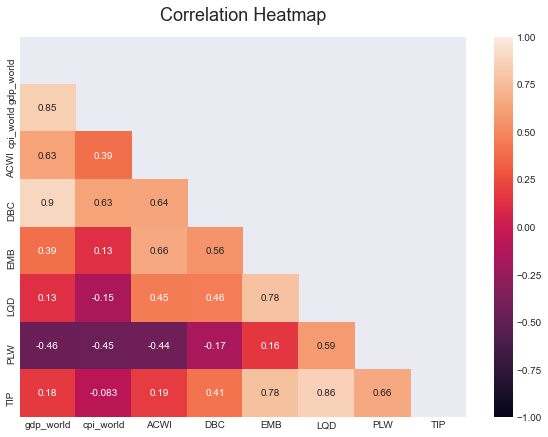

In [89]:
corr = corr_df.corr()

plt.figure(figsize=(10, 7))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(corr, dtype=np.bool))
heatmap = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [90]:
corr_df = pd.DataFrame(corr)
corr_df

gdp_world  cpi_world      ACWI       DBC       EMB       LQD  \
gdp_world   1.000000   0.847781  0.626498  0.896384  0.394733  0.129058   
cpi_world   0.847781   1.000000  0.394897  0.631361  0.125621 -0.154587   
ACWI        0.626498   0.394897  1.000000  0.638313  0.661495  0.446780   
DBC         0.896384   0.631361  0.638313  1.000000  0.559480  0.455849   
EMB         0.394733   0.125621  0.661495  0.559480  1.000000  0.781505   
LQD         0.129058  -0.154587  0.446780  0.455849  0.781505  1.000000   
PLW        -0.456979  -0.449740 -0.437052 -0.166505  0.161104  0.590852   
TIP         0.175250  -0.082839  0.187005  0.407531  0.775040  0.861966   

                PLW       TIP  
gdp_world -0.456979  0.175250  
cpi_world -0.449740 -0.082839  
ACWI      -0.437052  0.187005  
DBC       -0.166505  0.407531  
EMB        0.161104  0.775040  
LQD        0.590852  0.861966  
PLW        1.000000  0.655773  
TIP        0.655773  1.000000

In [91]:
corr_df.drop(tickers, axis=1, inplace=True)
corr_df = corr_df[2:]
corr_df

gdp_world  cpi_world
ACWI   0.626498   0.394897
DBC    0.896384   0.631361
EMB    0.394733   0.125621
LQD    0.129058  -0.154587
PLW   -0.456979  -0.449740
TIP    0.175250  -0.082839

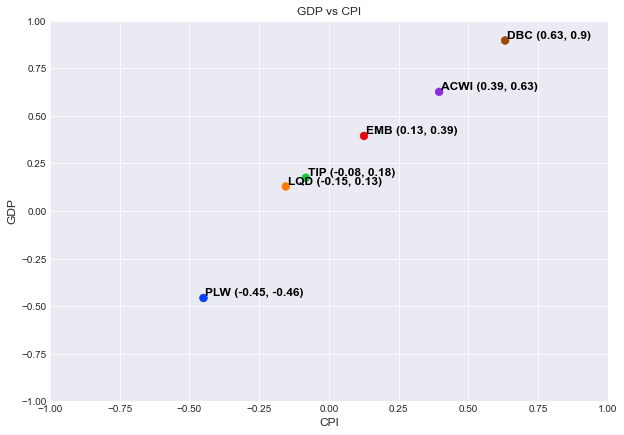

In [92]:
# Define size of graph
plt.figure(figsize=(10, 7))

sns.set_style('darkgrid')
ax = sns.scatterplot(y="gdp_world", x="cpi_world", edgecolor='face',
                     data=corr_df, palette='bright', s=60, hue='cpi_world')

# Define length of X and Y axis
ax.set_xlim(xmin=-1, xmax=1)
ax.set_ylim(ymin=-1, ymax=1)

# Title of the plot
plt.title('GDP vs CPI')

# Define labels
plt.xlabel('CPI', fontsize=12)
plt.ylabel('GDP', fontsize=12)

for i in range(0, corr_df.shape[0]):
    # Plot respective tag names and coordinates over each point
    plt.text(corr_df['cpi_world'][i]+0.007, corr_df['gdp_world'][i],
             s=f"{corr_df.index[i]} ({round(corr_df['cpi_world'][i], 2)}, {round(corr_df['gdp_world'][i], 2)})",
             horizontalalignment='left',
             verticalalignment='bottom',
             size='large',
             color='black',
             weight='semibold')


# Removing legends
ax.get_legend().remove()

### Merge monthly returns training set with correlation matrix

In [93]:
train_transpose = train_mo.T

In [94]:
train_dataset = train_transpose.merge(
    corr_df, left_index=True, right_index=True)

round(train_dataset.head(), 2)

2008-07-01 00:00:00  2008-08-01 00:00:00  2008-09-01 00:00:00  \
ACWI                -0.03                -0.02                -0.12   
DBC                 -0.10                -0.07                -0.10   
EMB                  0.01                 0.01                -0.07   
LQD                  0.00                 0.00                -0.11   
PLW                  0.00                 0.02                 0.01   

      2008-10-01 00:00:00  2008-11-01 00:00:00  2008-12-01 00:00:00  \
ACWI                -0.18                -0.09                 0.05   
DBC                 -0.25                -0.12                -0.05   
EMB                 -0.19                 0.09                 0.17   
LQD                 -0.02                 0.03                 0.13   
PLW                 -0.02                 0.10                 0.07   

      2009-01-01 00:00:00  2009-02-01 00:00:00  2009-03-01 00:00:00  \
ACWI                -0.11                -0.10                 0.09   
DBC                 -0.03                -0.06                 0.05   
EMB                 -0.06                -0.06                 0.05   
LQD                 -0.01                -0.06                 0.00   
PLW                 -0.07                -0.01                 0.04   

      2009-04-01 00:00:00  ...  2015-11-01 00:00:00  2015-12-01 00:00:00  \
ACWI                 0.13  ...                -0.01                -0.03   
DBC                 -0.00  ...                -0.07                -0.06   
EMB                  0.08  ...                 0.00                -0.02   
LQD                  0.03  ...                -0.00                -0.01   
PLW                 -0.04  ...                -0.01                -0.00   

      2016-01-01 00:00:00  2016-02-01 00:00:00  2016-03-01 00:00:00  \
ACWI                -0.04                -0.01                 0.07   
DBC                 -0.04                -0.00                 0.04   
EMB                  0.01                 0.01                 0.03   
LQD                  0.01                 0.01                 0.04   
PLW                  0.03                 0.02                 0.00   

      2016-04-01 00:00:00  2016-05-01 00:00:00  2016-06-01 00:00:00  \
ACWI                 0.01                 0.00                -0.01   
DBC                  0.10                 0.01                 0.04   
EMB                  0.02                -0.00                 0.04   
LQD                  0.02                -0.01                 0.03   
PLW                 -0.01                 0.00                 0.04   

      gdp_world  cpi_world  
ACWI       0.63       0.39  
DBC        0.90       0.63  
EMB        0.39       0.13  
LQD        0.13      -0.15  
PLW       -0.46      -0.45  

[5 rows x 98 columns]

### Scale the train set

In [95]:
train_dataset_scaled = pd.DataFrame(StandardScaler().fit_transform(train_dataset),
                                    columns=[train_dataset.columns],
                                    index=train_dataset.index)

In [96]:
train_dataset_scaled.head()

2008-07-01 00:00:00 2008-08-01 00:00:00 2008-09-01 00:00:00  \
ACWI           -0.321449           -0.293722           -1.106058   
DBC            -2.090559           -2.083285           -0.663500   
EMB             0.751284            0.566101            0.014966   
LQD             0.633922            0.362875           -0.767942   
PLW             0.641436            0.915200            1.792707   

     2008-10-01 00:00:00 2008-11-01 00:00:00 2008-12-01 00:00:00  \
ACWI           -0.661634           -1.098712           -0.299060   
DBC            -1.399618           -1.525358           -1.786280   
EMB            -0.772647            1.048779            1.408570   
LQD             1.158961            0.326679            0.844616   
PLW             1.198319            1.114174           -0.019752   

     2009-01-01 00:00:00 2009-02-01 00:00:00 2009-03-01 00:00:00  \
ACWI           -1.685794           -1.653062            1.675570   
DBC             0.466328           -0.196801           -0.074990   
EMB            -0.315368           -0.375981            0.082218   
LQD             0.985471           -0.211296           -1.690808   
PLW            -0.652444            1.409385           -0.396755   

     2009-04-01 00:00:00  ... 2015-11-01 00:00:00 2015-12-01 00:00:00  \
ACWI            1.702476  ...            0.307037           -0.573507   
DBC            -0.488643  ...           -2.217900           -1.898038   
EMB             0.840745  ...            0.668853            0.143507   
LQD            -0.006135  ...            0.465316            0.490163   
PLW            -1.194303  ...            0.285536            1.162655   

     2016-01-01 00:00:00 2016-02-01 00:00:00 2016-03-01 00:00:00  \
ACWI           -1.304371           -1.742599            1.772029   
DBC            -1.396538           -0.808000            0.376939   
EMB             0.434923            0.654109           -0.036273   
LQD             0.344868            0.102891            0.104639   
PLW             1.272697            1.259803           -1.460291   

     2016-04-01 00:00:00 2016-05-01 00:00:00 2016-06-01 00:00:00 gdp_world  \
ACWI           -0.282858            0.619085           -2.063966  0.780146   
DBC             2.174834            1.683549            0.772561  1.413685   
EMB            -0.213011           -0.391069            0.667674  0.236094   
LQD            -0.215649           -0.981292            0.142525 -0.387559   
PLW            -0.849049            0.320301            0.770373 -1.763240   

     cpi_world  
ACWI  0.887647  
DBC   1.548855  
EMB   0.134690  
LQD  -0.648833  
PLW  -1.474148  

[5 rows x 98 columns]

### Create the dendrogram

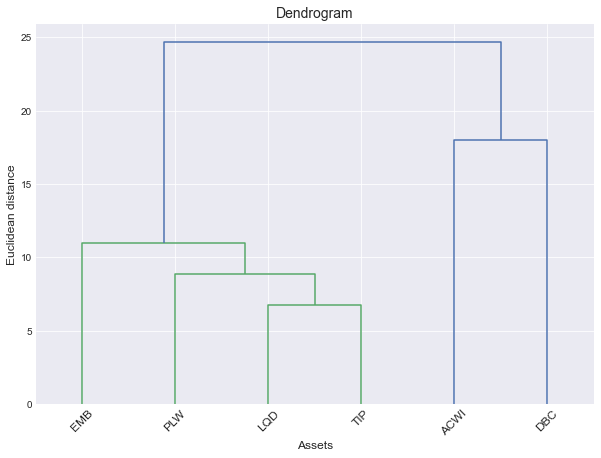

In [97]:
# Define the size of the graph
plt.figure(figsize=(10, 7))

# Title of the chart
plt.title('Dendrogram', fontsize=14)

# Create linkage matrix
linkage_matrix = linkage(train_dataset_scaled, method='ward')

# Create dendrogram
dendrogram(linkage_matrix, labels=train_dataset_scaled.index)

# Define labels
plt.xlabel("Assets", fontsize=12)
plt.ylabel('Euclidean distance', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### Compare scatterplot with dendrogram

In [98]:
def compare_plots(data, data_scaled):
    # Define size of graph
    plt.figure(figsize=(18, 7))

    """
    GDP vs CPI subplot
    """
    # Define position of 1st subplot
    plt.subplot(1, 2, 1)

    sns.set_style('darkgrid')
    ax = sns.scatterplot(y="gdp_world", x="cpi_world", edgecolor='face',
                         data=corr_df, palette='bright', s=60, hue='cpi_world')

    # Finding max values of ROE and NPM
    # These values are used to define the length of the X and Y-axis
    max_gdp = round(data.gdp_world.max()+0.1, 2)
    max_cpi = round(data.cpi_world.max()+0.3, 2)
    
    min_gdp = round(data.gdp_world.min()-0.4, 2)
    min_cpi = round(data.cpi_world.min()-0.4, 2)

    # Define length of X and Y axis
    ax.set_xlim(xmin=min_cpi, xmax=max_cpi)
    ax.set_ylim(ymin=min_gdp, ymax=max_gdp)

    # Title of the plot
    plt.title('GDP vs CPI')

    # Define labels
    plt.xlabel('CPI', size=12)
    plt.ylabel('GDP', size=12)

    for i in range(0, data.shape[0]):
        plt.text(data['cpi_world'][i]+0.009, data['gdp_world'][i]-0.001,
                 # Plot respective tag names and coordinates over each point.
                 s=f"{data.index[i]} ({round(data['cpi_world'][i], 2)}, {round(data['gdp_world'][i], 2)})",
                 horizontalalignment='left',
                 verticalalignment='bottom',
                 size='large',
                 color='black',
                 weight='semibold')

    # Removing legends
    ax.get_legend().remove()

    """
    Hierarchical Clustering Dendrogram Subplot
    """
    # Define position of 2nd subplot
    plt.subplot(1, 2, 2)

    # Title of the chart
    plt.title('Hierarchical Clustering Dendrogram')

    # Create linkage matrix
    linkage_matrix = linkage(data_scaled, method='ward')

    # Plot dendrogram
    dendrogram(linkage_matrix, labels=data_scaled.index)

    # Define labels
    plt.xlabel("Assets")
    plt.ylabel('Euclidean distance')

    return plt.show()

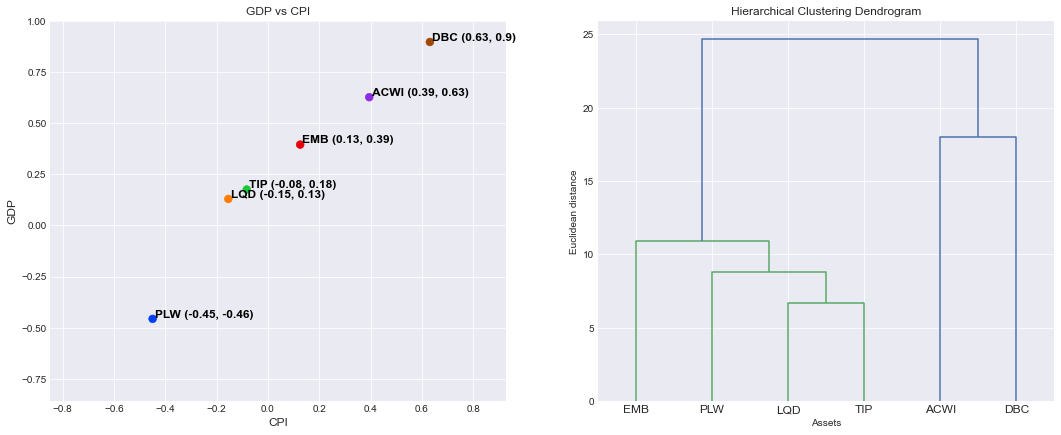

In [99]:
# Call compare_plot function
compare_plots(corr_df, train_dataset_scaled)

### Finding weights for each single cluster

In [100]:
# Function to calculate cluster volatility
def calculate_cluster_volatility(returns_data, tickers):

    # Calculating the standard deviation of assets returns in the tickers list
    volatility = returns_data[tickers].std()

    # Calculate the weights of assets using inverse volatility method
    weights = (1/volatility)/np.sum(1/volatility)

    # Multiply the returns data with weights calculated to get cluster returns
    cluster_returns = returns_data[tickers].dot(weights)

    # Calculate the volatility of cluster using standard deviation of cluster returns
    cluster_volatility = cluster_returns.std()

    return cluster_volatility

In [101]:
def hrp_weights(tickers, dataset, returns_data,weights_hrp_initital):

    if len(tickers) > 1:
        
        input_df = dataset.loc[tickers]

        # Hierarchical Clustering using Agglomerative Clustering

        # Step 1: Define an agglomerative clustering model
        model = AgglomerativeClustering(
            n_clusters=2, affinity='euclidean', linkage='ward')
        
        # Step 2: Call fit_predict_method on dataset
        clusters = model.fit_predict(input_df)

        # Step 3: Get tickers of cluster_0 and cluster_1
        cluster_0 = input_df.loc[clusters == 0, :].index
        
        cluster_1 = input_df.loc[clusters == 1, :].index
        
        # Step-4: Calculate the volatility of cluster_0 and cluster_1 
        cluster_0_volatility  = calculate_cluster_volatility(returns_data[cluster_0], cluster_0)
        
        cluster_1_volatility  = calculate_cluster_volatility(returns_data[cluster_1], cluster_1)

        # Step-5: Calculate the weights of cluster_0 and cluster_1
        weight_cluster_0 = (1/cluster_0_volatility)/((1/cluster_0_volatility)+(1/cluster_1_volatility))
        
        weight_cluster_1 = (1/cluster_1_volatility)/((1/cluster_0_volatility)+(1/cluster_1_volatility))

        # Multiply the weights of tickers in 'weights_hrp_initial' dataframe with respective weights of cluster_0 and cluster_1
        weights_hrp_initital.loc[cluster_0, 'HRP'] *= weight_cluster_0
        
        weights_hrp_initital.loc[cluster_1, 'HRP'] *= weight_cluster_1

        # Run the clustering algorithm on the new clusters i.e. cluster_0 and cluster_1
        hrp_weights(cluster_0, dataset, returns_data, weights_hrp_initital)
        
        hrp_weights(cluster_1, dataset, returns_data, weights_hrp_initital)
        
        # Create weights_hrp dataframe
        weights_hrp = weights_hrp_initital

        # output weights_hrp
        return weights_hrp

In [102]:
# Assets' weights
assets = train_dataset_scaled.index.to_list()
weights_hrp_initital = pd.DataFrame(
        [1]*len(assets), index=assets, columns=['HRP'])
weights_hrp = hrp_weights(assets,train_dataset_scaled, train_mo,weights_hrp_initital)
round(weights_hrp.head(6), 2)

HRP
ACWI  0.15
DBC   0.14
EMB   0.24
LQD   0.12
PLW   0.20
TIP   0.15

In [103]:
print(weights_hrp.sum(axis=0))

HRP    1.0
dtype: float64


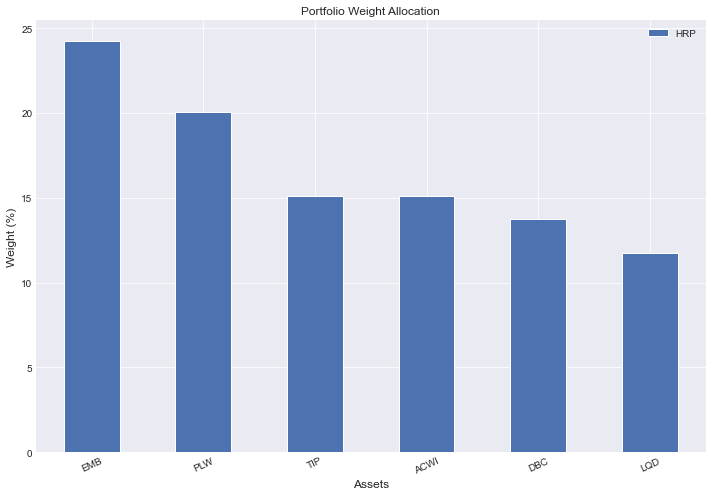

In [104]:
weights = weights_hrp

# Percentage weights
percentage_weights = (weights * 100).sort_values(by='HRP', ascending=False)

# Bar plot
percentage_weights.plot.bar(
    figsize=(10, 7), title='Portfolio Weight Allocation', rot=25)

# Set lables for the plot
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Weight (%)', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

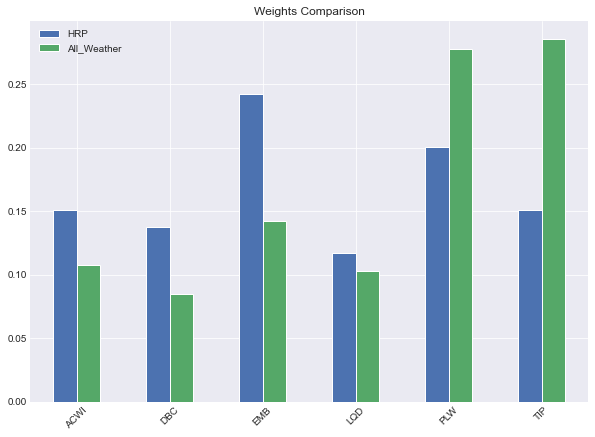

In [105]:
weights.merge(aw_weights, left_index=True, right_index=True).plot(
    kind='bar', grid=True, figsize=(10, 7), rot=45, title='Weights Comparison');

### Weights comparison

In [106]:
weights_comp = pd.concat([weights_df_T, aw_weights, weights_hrp], join='outer', axis=1)
weights_comp.head()

MVO  All_Weather       HRP
ACWI  0.31753     0.107358  0.151038
DBC   0.28850     0.084557  0.137399
EMB   0.15345     0.142263  0.242522
LQD   0.12536     0.102904  0.117406
PLW   0.04513     0.277499  0.200393

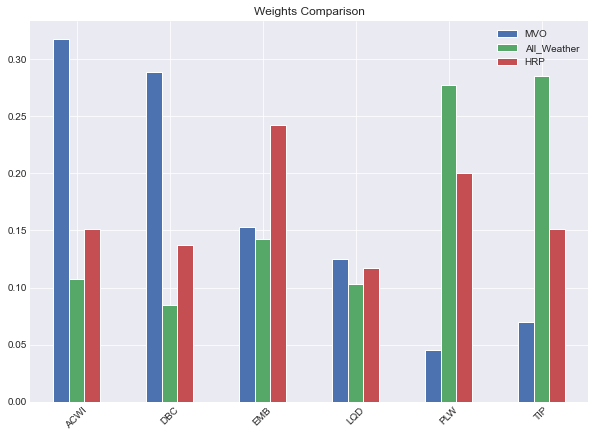

In [107]:
weights_comp.plot(
    kind='bar', grid=True, figsize=(10, 7), rot=45, title='Weights Comparison');

### Performance analysis

Portfolio return :  26.27 %


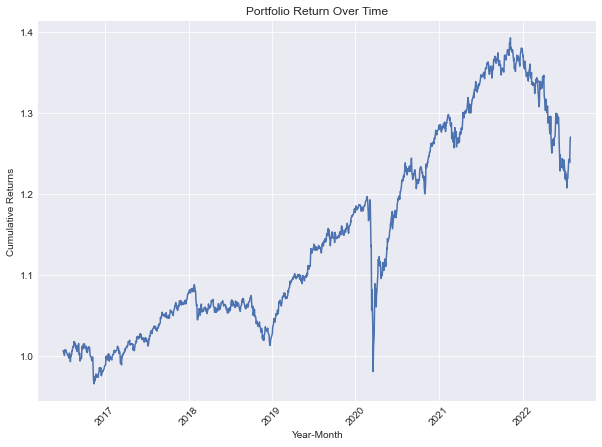

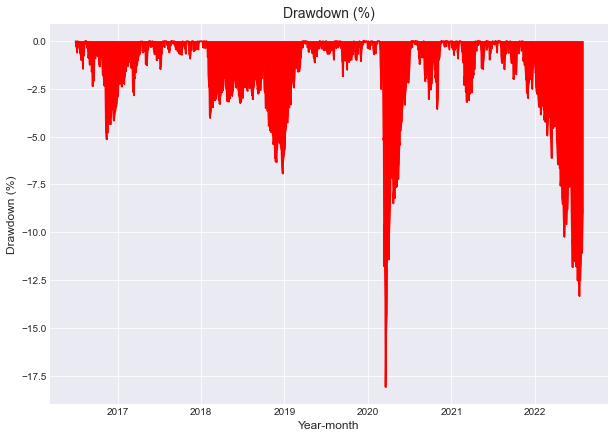

Sharpe ratio  Annualised returns (CAGR)  \
Performance Metrics          0.58                       3.92   

                     Maximum drawdown (MDD)  Return-to-MDD ratio  
Performance Metrics                  -18.09                 0.22

In [108]:
# Performance metrics
performance_metrics = portfolio_performance(returns_test, weights_hrp['HRP'])
performance_metrics

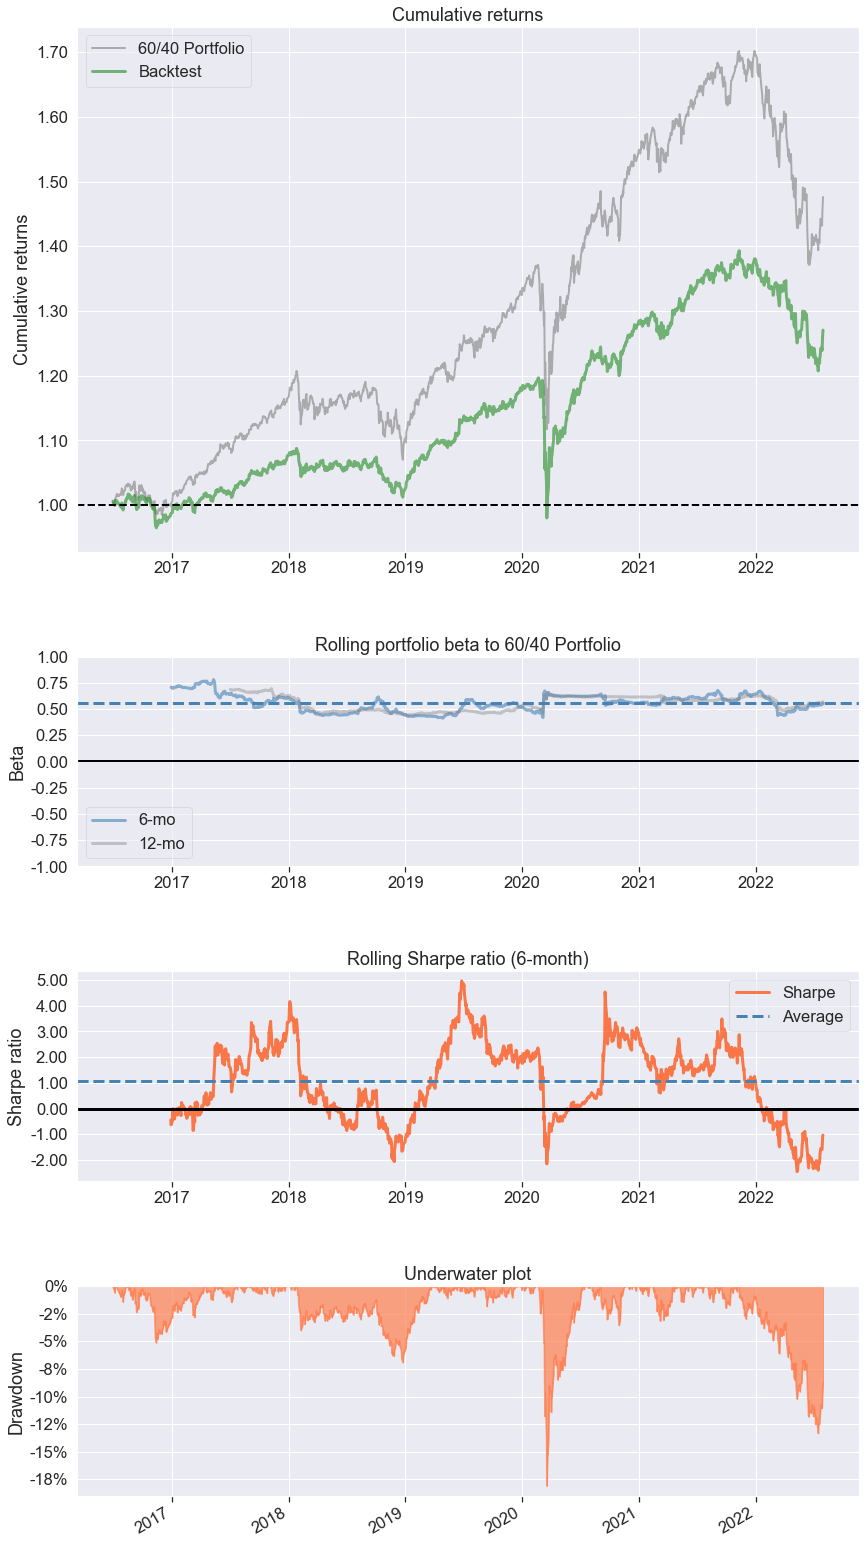

In [109]:
# Portfolio returns
hrp_returns = (weights_hrp['HRP'] * returns_test).sum(axis=1)
pf.create_simple_tear_sheet(hrp_returns, benchmark_rets=bmk_rets, set_context=True)

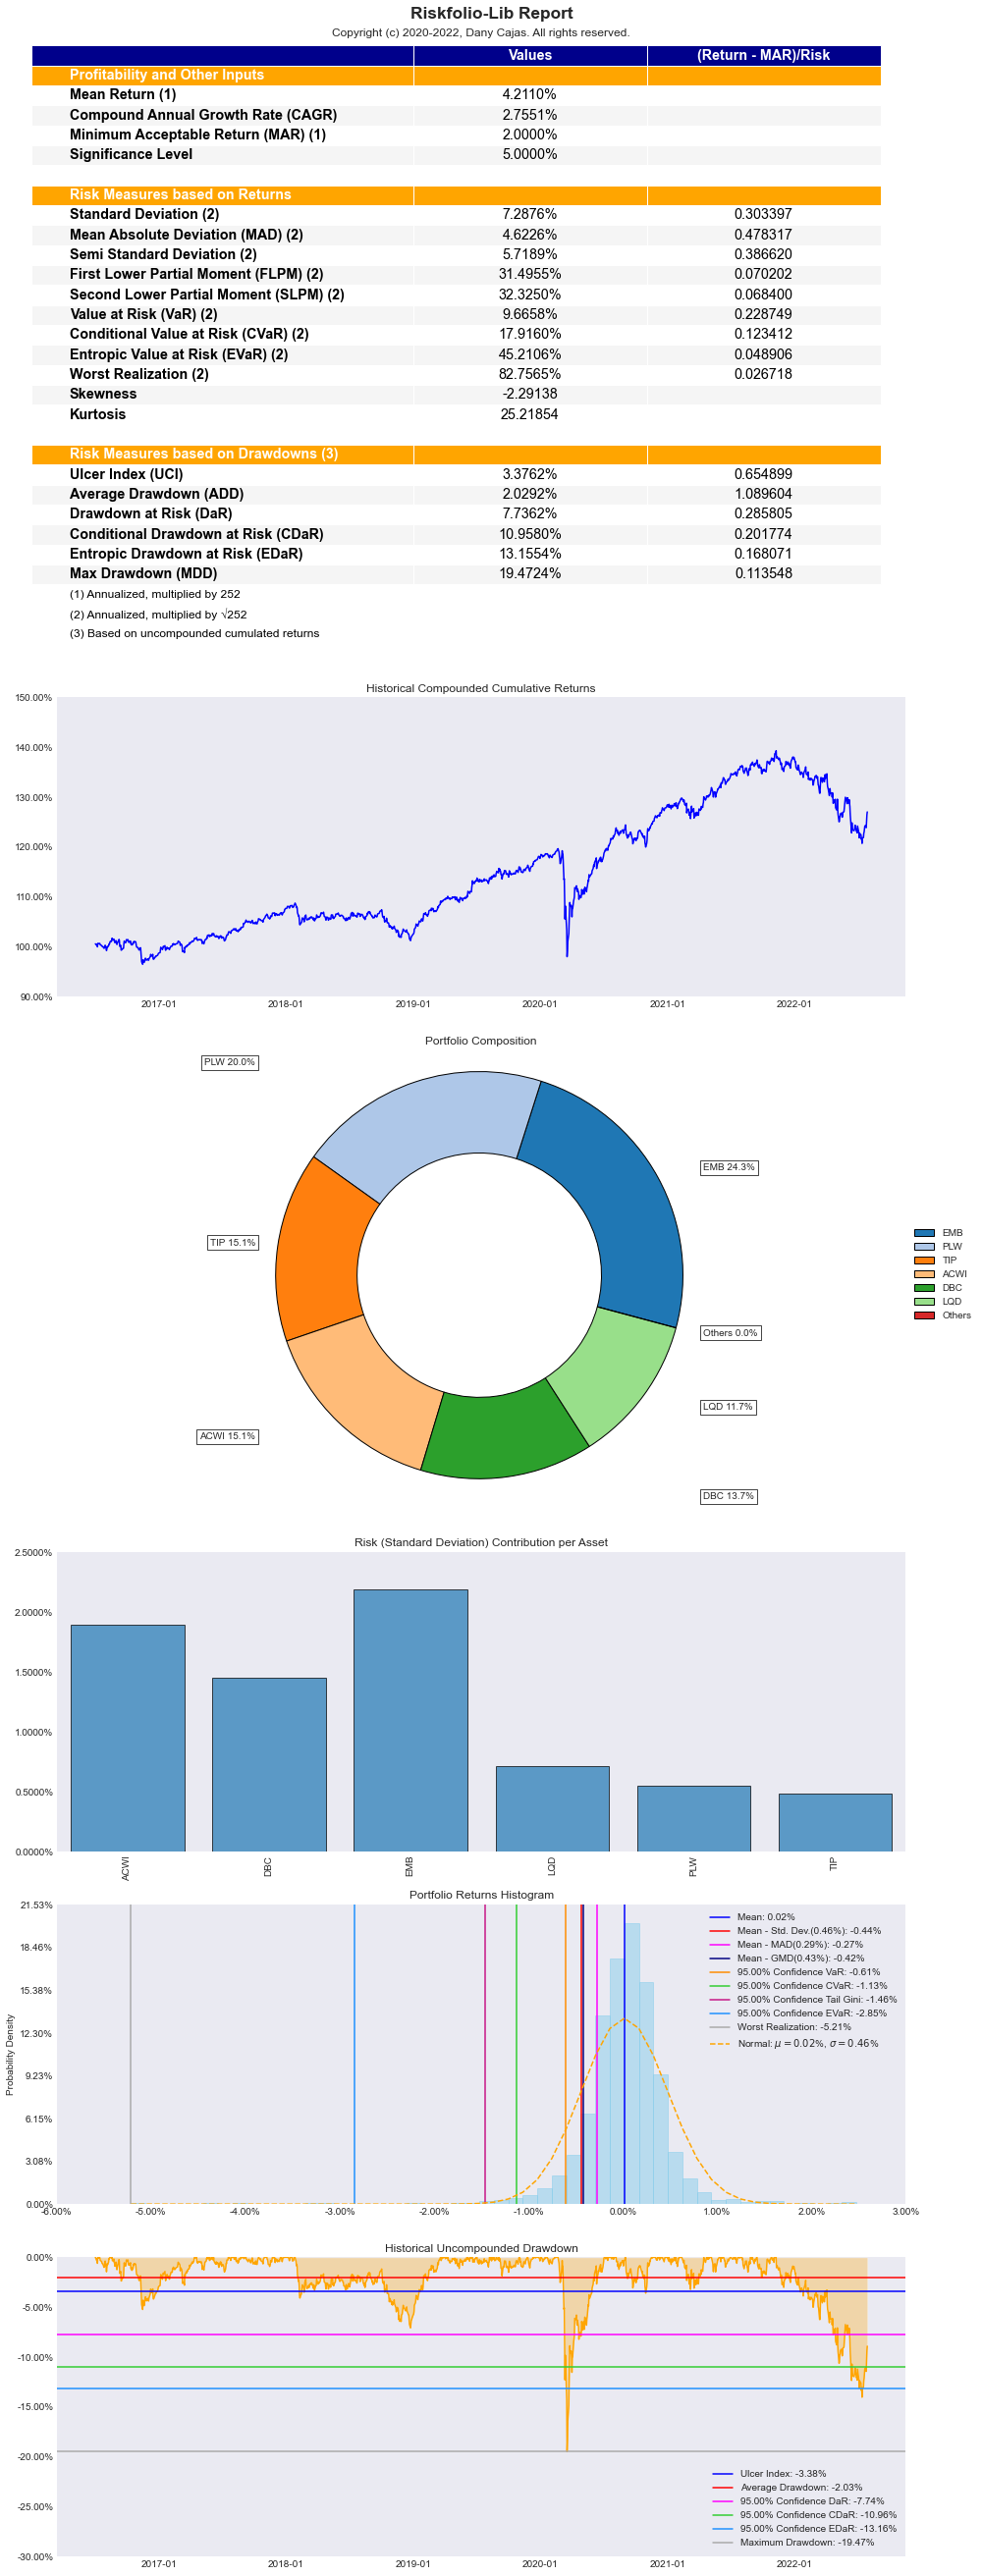

In [110]:
rm = 'MV' 

ax = rp.jupyter_report(returns_test,
                       weights_hrp,
                       rm=rm,
                       rf=0.02,
                       alpha=0.05,
                       others=0.05,
                       nrow=25,
                       height=6,
                       width=14,
                       t_factor=252,
                       ini_days=1,
                       days_per_year=252,
                       bins=50,
                       )

## Comparing all portfolios

In [111]:
def portfolio_performance(returns, asset_weight, plot=True):

    # Portfolio returns
    portfolio_returns = (asset_weight * returns).sum(axis=1)

    # Portfolio returns
    portfolio_cum = (1 + portfolio_returns).cumprod()
    total_return = portfolio_cum.iloc[-1] / portfolio_cum.iloc[0] - 1

    if plot:
        # Plotting portfolio returns
        plt.figure(figsize=(10, 7))
        plt.plot(portfolio_cum)
        plt.title("Portfolio Return Over Time")
        plt.xlabel("Year-Month")
        plt.ylabel("Cumulative Returns")
        plt.tick_params(axis="x", rotation=45)
        plt.show()

    # Annualised performance
    annualised_performance = ((portfolio_cum.iloc[-1] / portfolio_cum.iloc[0])
                              ** (252 / len(portfolio_returns)) - 1) * 100

    # Drawdown calculations
    # Calculate the running maximum
    running_max = np.maximum.accumulate(portfolio_cum.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    running_drawdown = 100 * ((portfolio_cum) / running_max - 1)

    # Calculate the maximum drawdown
    max_drawdown = running_drawdown.min()

    # Calculate the return to max. drawdown ratio
    return_to_MDD_ratio = annualised_performance / max_drawdown

    # Sharpe Ratio
    sharpe = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

    # Plot max drawdown
    if plot:
        plt.figure(figsize=(10, 7))
        plt.title("Drawdown (%)", fontsize=14)
        plt.plot(running_drawdown, color="red")
        plt.xlabel("Year-month", fontsize=12)
        plt.ylabel("Drawdown (%)", fontsize=12)
        plt.fill_between(running_drawdown.index, running_drawdown.values, color="red")
        plt.show()

    # Print the performance metrics
    performance_metrics = pd.DataFrame(
        {'Portfolio returns (%)': round(100 * total_return, 2), 'Sharpe ratio': round(sharpe, 2),
         'Annualised returns (CAGR) (%)': round(annualised_performance, 2),
         'Maximum drawdown (MDD) (%)': round(max_drawdown, 2), 'Return-to-MDD ratio': abs(round(return_to_MDD_ratio, 2))},
        index=['Performance Metrics'])
    return performance_metrics

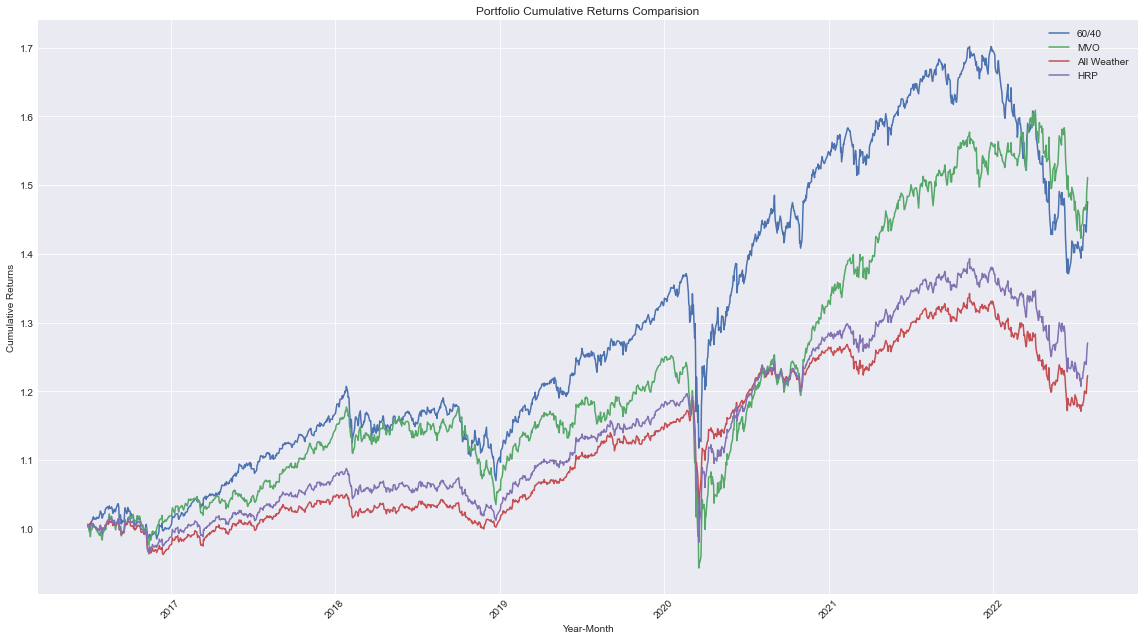

In [112]:
# Calculating returns for each type of portfolio 
#'@' indicates matrix multiplication
sixty_forty_returns = returns_test_60_40 @ sixty_forty_weights['60/40']
mvo_returns = returns_test @ weights_df_T['MVO']
aw_returns = returns_test @ aw_weights['All_Weather']
hrp_returns = returns_test @ weights_hrp['HRP']

# 60/40 Cumulative returns
sixty_forty_cum_rets = (1 + sixty_forty_returns).cumprod()

# MVO Cumulative returns
mvo_cum_rets = (1 + mvo_returns).cumprod()

# All Weather Cumulative returns
aw_cum_rets = (1 + aw_returns).cumprod()

# HRP returns
hrp_cum_rets = (1 + hrp_returns).cumprod()

# Plot size
plt.figure(figsize=(16, 9))

# Plot title
plt.title('Portfolio Cumulative Returns Comparision')

plt.tick_params(axis='x', rotation=45)

# Plot labels
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Returns')
plt.plot(sixty_forty_cum_rets, label='60/40')
plt.plot(mvo_cum_rets, label='MVO')
plt.plot(aw_cum_rets, label='All Weather')
plt.plot(hrp_cum_rets, label='HRP')

# Plot Legend
plt.legend()

# Display Plot
plt.tight_layout()
plt.show()

In [113]:
# Performance metrics of 60/40 Portfolio
performance_metrics_sixty_forty = portfolio_performance(
    returns_test_60_40, sixty_forty_weights['60/40'], plot=False)

performance_metrics_sixty_forty.rename(
    index={'Performance Metrics': '60/40'}, inplace=True
)

# Performance metrics of MVO Portfolio
performance_metrics_mvo = portfolio_performance(
    returns_test, weights_df_T['MVO'], plot=False)

performance_metrics_mvo.rename(
    index={'Performance Metrics': 'MVO - Max Sharpe'}, inplace=True
)

# Performance metrics of All Weather Portfolio
performance_metrics_aw = portfolio_performance(
    returns_test, aw_weights['All_Weather'], plot=False)

performance_metrics_aw.rename(
    index={'Performance Metrics': 'All Weather'}, inplace=True
)


# Performance metrics of HRP Portfolio
performance_metrics_HRP = portfolio_performance(
    returns_test, weights_hrp['HRP'], plot=False)

performance_metrics_HRP.rename(
    index={'Performance Metrics': 'HRP'}, inplace=True
)

pd.concat([performance_metrics_sixty_forty, 
           performance_metrics_mvo, 
           performance_metrics_aw, 
           performance_metrics_HRP])

Portfolio returns (%)  Sharpe ratio  \
60/40                             47.00          0.67   
MVO - Max Sharpe                  50.16          0.70   
All Weather                       21.50          0.57   
HRP                               26.27          0.58   

                  Annualised returns (CAGR) (%)  Maximum drawdown (MDD) (%)  \
60/40                                      6.55                      -19.43   
MVO - Max Sharpe                           6.93                      -24.68   
All Weather                                3.26                      -14.74   
HRP                                        3.92                      -18.09   

                  Return-to-MDD ratio  
60/40                            0.34  
MVO - Max Sharpe                 0.28  
All Weather                      0.22  
HRP                              0.22

## Whole period comparison

In [114]:
monthly_rets_60_40 = monthly_rets[['ACWI', 'PLW']]

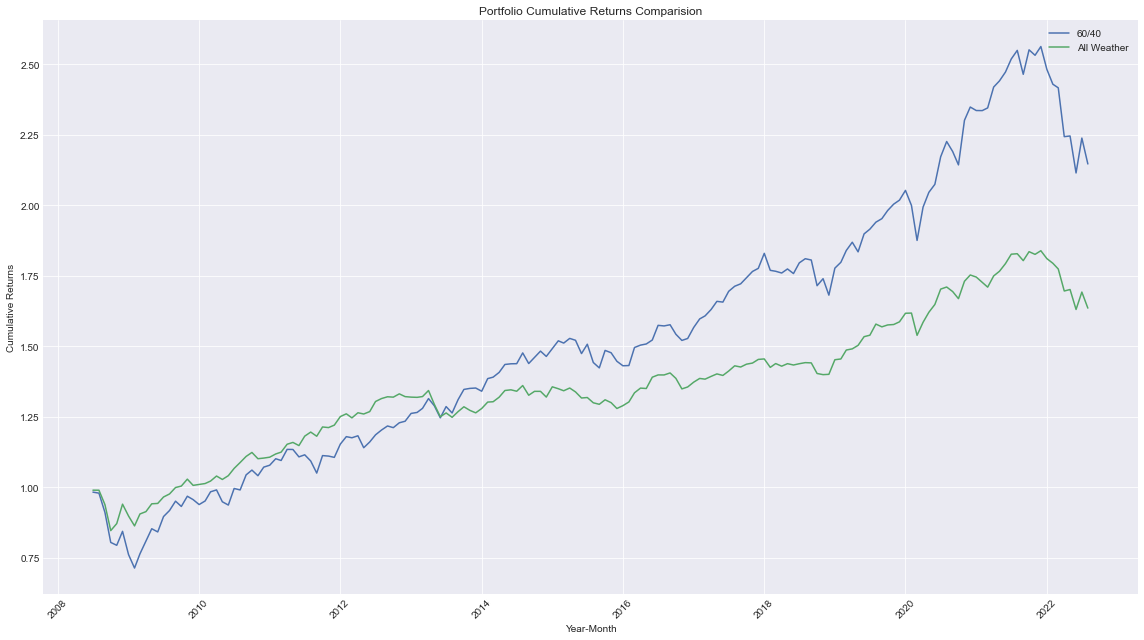

In [115]:
# Calculating returns for each type of portfolio 
#'@' indicates matrix multiplication
sixty_forty_returns = monthly_rets_60_40 @ sixty_forty_weights['60/40']
aw_returns = monthly_rets @ aw_weights['All_Weather']

# 60/40 Cumulative returns
sixty_forty_cum_rets = (1 + sixty_forty_returns).cumprod()

# All Weather Cumulative returns
aw_cum_rets = (1 + aw_returns).cumprod()


# Plot size
plt.figure(figsize=(16, 9))

# Plot title
plt.title('Portfolio Cumulative Returns Comparision')

plt.tick_params(axis='x', rotation=45)

# Plot labels
plt.xlabel('Year-Month')
plt.ylabel('Cumulative Returns')
plt.plot(sixty_forty_cum_rets, label='60/40')
plt.plot(aw_cum_rets, label='All Weather')


# Plot Legend
plt.legend()

# Display Plot
plt.tight_layout()
plt.show()

In [116]:
# Performance metrics of 60/40 Portfolio
performance_metrics_sixty_forty = portfolio_performance(
    monthly_rets_60_40, sixty_forty_weights['60/40'], plot=False)

performance_metrics_sixty_forty.rename(
    index={'Performance Metrics': '60/40'}, inplace=True
)

# Performance metrics of All Weather Portfolio
performance_metrics_aw = portfolio_performance(
    monthly_rets, aw_weights['All_Weather'], plot=False)

performance_metrics_aw.rename(
    index={'Performance Metrics': 'All Weather'}, inplace=True
)

pd.concat([performance_metrics_sixty_forty, performance_metrics_aw])

Portfolio returns (%)  Sharpe ratio  \
60/40                       118.39          2.62   
All Weather                  65.22          2.48   

             Annualised returns (CAGR) (%)  Maximum drawdown (MDD) (%)  \
60/40                               218.33                      -28.63   
All Weather                         110.50                      -15.36   

             Return-to-MDD ratio  
60/40                       7.63  
All Weather                 7.19